# Homework #5. Exploratory Data Analysis
### Author: `Nataliia Yandola`
### Total time spent on h/w (minutes): `2550`

In [2]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from PIL import Image
from matplotlib_venn import venn3
from langdetect import detect
import matplotlib.pyplot as plt
import datetime
import emoji
import regex
from utils.dict_manipulation import get_ua_tonality_dict_combined, get_ru_tonality_dict
from utils.date import get_day_and_hour, get_week_day_from_number
import plotly.graph_objects as go
from googletrans import Translator
import pycountry
import matplotlib.image as mpimg

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [375]:
DIALOGS_MERGED_DATA_PATH = "../css_нові_повідомлення/data/merged_data/dialogs_data_all.csv"
DIALOGS_META_MERGED_DATA_PATH = "../css_нові_повідомлення/data/merged_data/dialogs_users_all.csv"

In [4]:
df = pd.read_csv(DIALOGS_MERGED_DATA_PATH)
df_meta = pd.read_csv(DIALOGS_META_MERGED_DATA_PATH)

In [5]:
meta_merge = df_meta.copy().drop_duplicates(subset = 'dialog_id', keep = 'first').drop('users', axis = 1)
df_merged = pd.merge(df, meta_merge, on = "dialog_id")
df_merged.rename(columns = {'type_x':'type_message', 'type_y':'type_dialog'}, inplace = True)

## My ideas and research:
### 1. Research on the use of language using langdetect

#### Discussions about the use of ukrainian and russian languages are currently very popular, so I decided to count the number of messages written in these two languages.

In [11]:
df_lang = df.loc[(df['type'] == 'text') & (~df['message'].isnull()) & (df['message'].str.isnumeric()==False)].assign(language = None).reset_index()

In [12]:
for ind in df_lang.index:
    try:
        lang = detect(df_lang['message'][ind])
    except:
        lang = 'error'
    df_lang.at[ind, 'language'] = lang

In [13]:
df_lang_main = df_lang.loc[(df_lang['language'] == 'uk')|(df_lang['language'] == 'ru')].reset_index()
df_lang_sent = df_lang_main.loc[df_lang_main['from_id'] == 'PeerUser(user_id=544639169)']
df_lang_rec = df_lang_main.loc[df_lang_main['to_id'] == '544639169']

In [285]:
colors = ['#8D8DAA', '#F56D91']
def pie_chart(df, caption, font_size):
    fig, chart = plt.subplots(figsize=(4.5, 4.5))
    pie1 = chart.pie(df.groupby(['language'])['language'].count(), 
       startangle=0, colors = colors, autopct = "%1.1f%%", wedgeprops={'width':0.3, 'linewidth' : 5, 'edgecolor' : 'white' },)
    plt.text(0, 0, "Mainly used \n languages", ha='center', va='center', fontsize=16)
    plt.text(0, -0.25, caption, ha='center', va='center', fontsize = font_size, color = '#212121')
    plt.legend(['russian', 'ukrainian'], loc="upper left", fontsize = 10)
    plt.show()

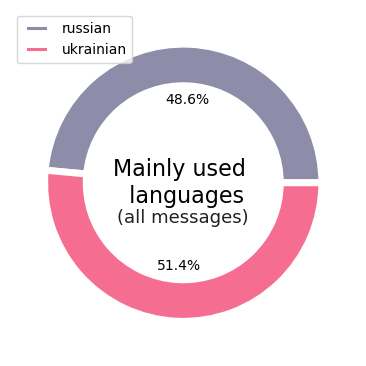

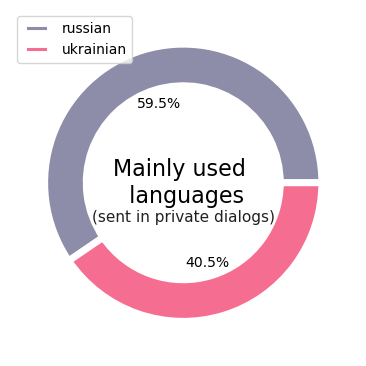

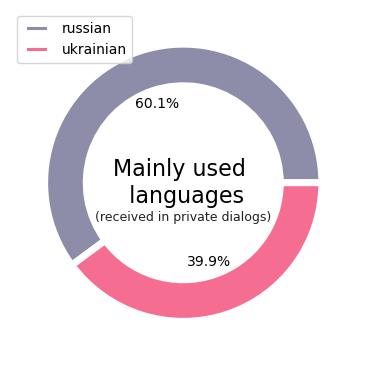

In [287]:
pie_chart(df_lang_main, '(all messages)', 13)
pie_chart(df_lang_sent, '(sent in private dialogs)', 11)
pie_chart(df_lang_rec, '(received in private dialogs)', 9)

### 2. Research on my own language use and progress during last 5 years and last 10 months

#### Continuing the topic of language discussion: I analyzed changes in the number of messages written in ukrainian and russian over time. My prediction was that there would be significant changes in 2021.

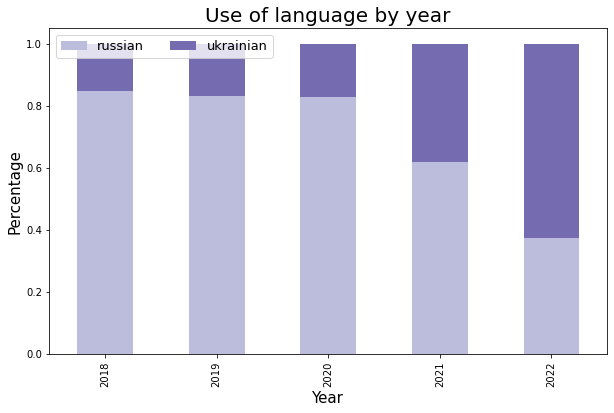

In [257]:
lang_sent_year = df_lang_sent.copy()
lang_sent_year['date'] = pd.DatetimeIndex(lang_sent_year['date']).year
cross_tab_lang = pd.crosstab(index = lang_sent_year['date'], columns = lang_sent_year['language'], normalize = 'index')
cross_tab_lang.plot(kind = 'bar', stacked = True, color = ['#bcbddc','#756bb1'], figsize = (10,6))
plt.legend(['russian', 'ukrainian'], loc="upper left", ncol = 2, fontsize = 13)
plt.ylabel('Percentage', fontsize = 15)
plt.xlabel('Year', fontsize = 15)
plt.title('Use of language by year', fontsize = 20)
plt.show()

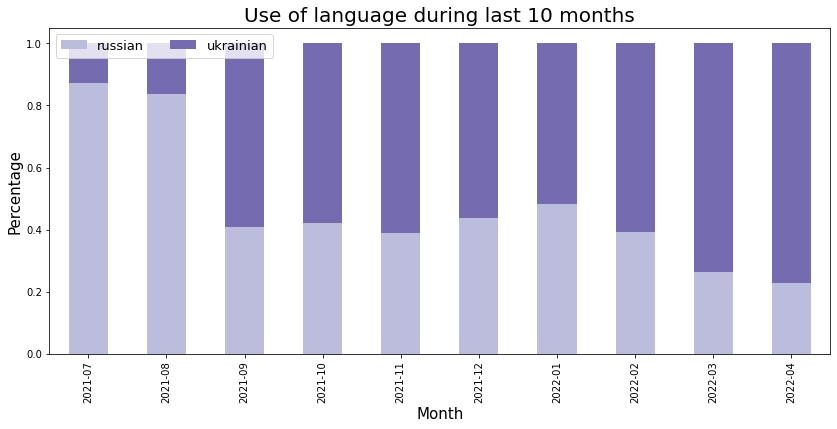

In [8]:
lang_sent_month = df_lang_sent.copy()
lang_sent_month['date'] = pd.to_datetime(lang_sent_month['date']).dt.strftime('%Y-%m') 
cross_tab_month = pd.crosstab(index = lang_sent_month['date'], columns = lang_sent_month['language'], normalize = 'index')[-10:]
cross_tab_month.plot(kind = 'bar', stacked = True, color = ['#bcbddc','#756bb1'], figsize = (14,6))
plt.legend(['russian', 'ukrainian'], loc="upper left", ncol = 2, fontsize = 13)
plt.ylabel('Percentage', fontsize = 15)
plt.xlabel('Month', fontsize = 15)
plt.title('Use of language during last 10 months', fontsize = 20)
plt.show()

#### Сonclusion: I actually started to use Ukrainian more actively in 2021, so my prediction was true.

### 3. Research on my close friends' language use

#### I also decided to look at the use of language by the people I talk to the most (10 closest friends). I assumed that about half of my close friends spoke ukrainian and half of them spoke russian.

In [214]:
top10 = df[(df.to_id == "544639169")&(df.dialog_id >0)].groupby(["dialog_id"])["message"].count().sort_values(ascending = False).head(11)
users = list(top10.keys())
top10 = df_lang_main.loc[(df_lang_main['dialog_id'].isin(users)) & (df_lang_main['from_id'] != 'PeerUser(user_id=544639169)')]
crosstab_top10 = pd.crosstab(index = top10['dialog_id'], columns = top10['language'], normalize = 'index')
crosstab_top10 = pd.merge(crosstab_top10, df_meta, on = 'dialog_id')

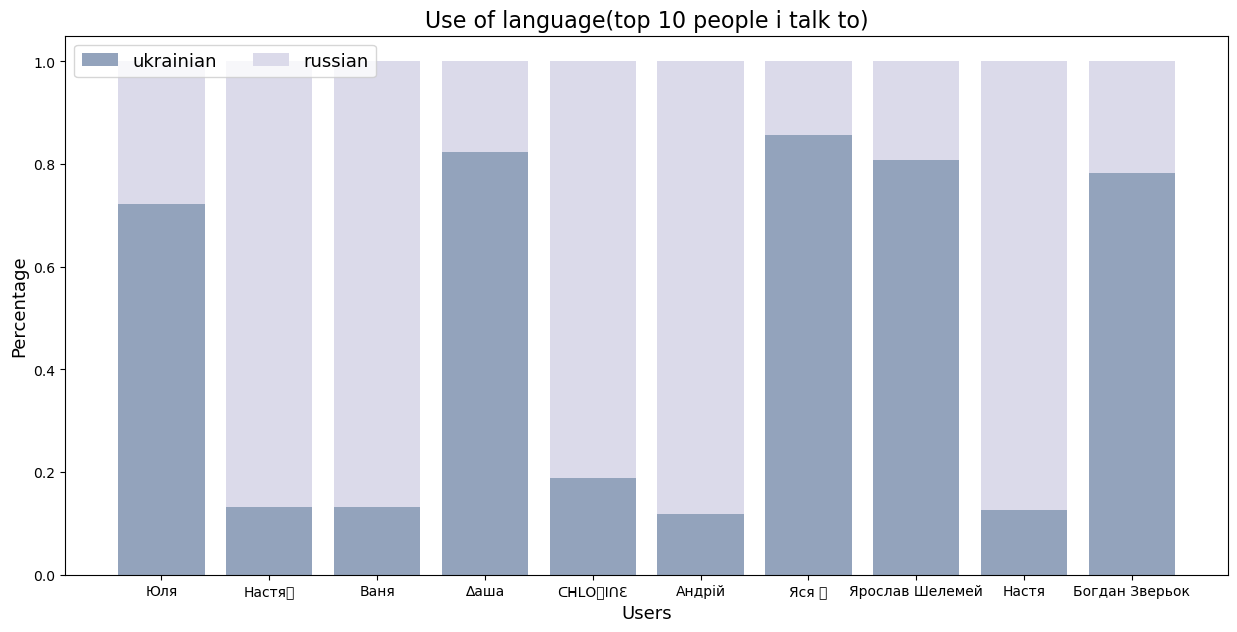

In [226]:
plt.rcParams['figure.figsize'] = (15,7)
plt.bar(crosstab_top10.name, crosstab_top10.uk, color='#93A3BC')
plt.bar(crosstab_top10.name, crosstab_top10.ru, bottom=crosstab_top10.uk, color='#DBDAEA')
plt.ylabel('Percentage', fontsize = 13)
plt.xlabel('Users', fontsize = 13)
plt.title('Use of language(top 10 people i talk to)', fontsize = 16)
plt.legend(['ukrainian', 'russian'], loc="upper left", ncol = 2, fontsize = 13)
plt.show()

#### Result: my assumptions were true.

### 4. People who i talked to the most from 2019 to 2022

#### In this question, I decided to look at how the circle of my closest friends has changed over the years.

In [ ]:
def get_year(df, year):
    res = df.loc[df['date'] == year].groupby('name')['message'].count().sort_values(ascending = False).head(5)
    return res.reset_index()

In [156]:
merged_private = df_merged.loc[df_merged['type_dialog'] == 'Private dialog']
merged_private['date'] = pd.DatetimeIndex(merged_private['date']).year
data_2019 = get_year(merged_private, 2019)
data_2020 = get_year(merged_private, 2020)
data_2021 = get_year(merged_private, 2021)
data_2022 = get_year(merged_private, 2022)

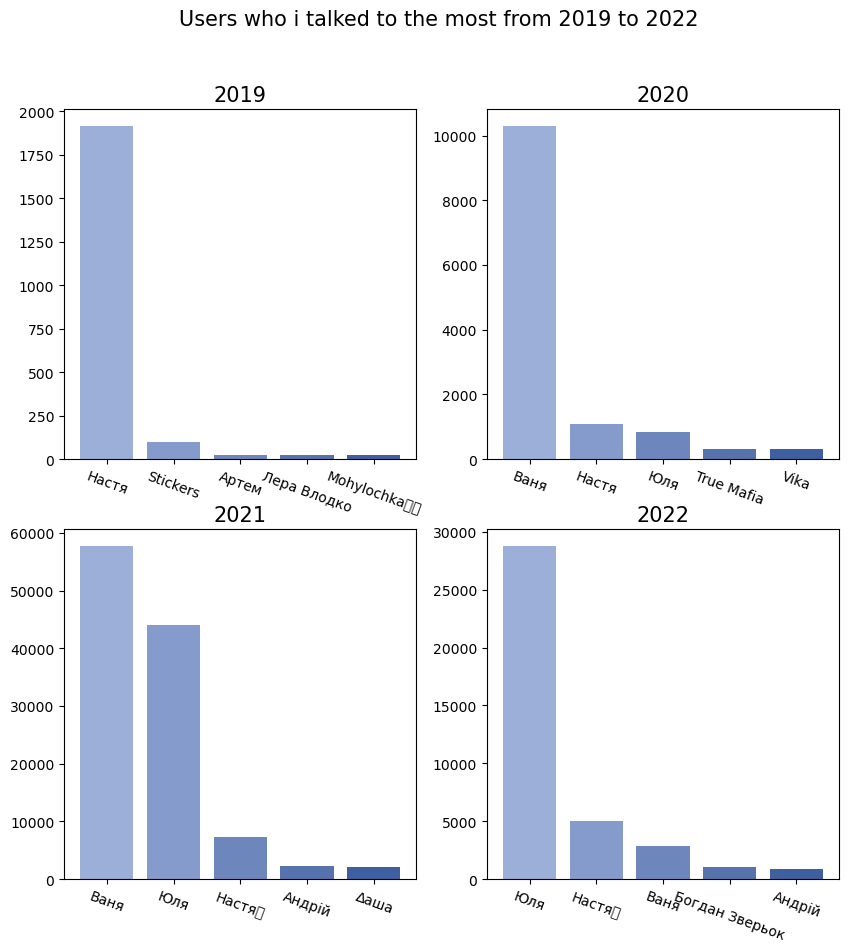

In [1228]:
colors = ['#9BAFD9', '#849BCB', '#6D87BC', '#5673AE', '#3E5FA0']
fig,ax=plt.subplots(2,2,figsize=(10,10))

ax[0,0].bar(data_2019.name,data_2019.message,color = colors )
ax[0,0].set_title('2019', fontsize = 15)
ax[0,0].set_xticklabels(data_2019.name, rotation = -20)

ax[0,1].bar(data_2020.name,data_2020.message,color= colors)
ax[0,1].set_title('2020', fontsize = 15)
ax[0,1].set_xticklabels(data_2020.name, rotation = -20)

ax[1,0].bar(data_2021.name,data_2021.message,color= colors)
ax[1,0].set_title('2021', fontsize = 15)
ax[1,0].set_xticklabels(data_2021.name, rotation = -20)

ax[1,1].bar(data_2022.name,data_2022.message,color= colors)
ax[1,1].set_title('2022', fontsize = 15)
ax[1,1].set_xticklabels(data_2022.name, rotation = -20)
fig.suptitle('Users who i talked to the most from 2019 to 2022', fontsize = 15)

plt.show()

### 5. Group chats where i sent the most messages

#### I'm not very active in group chats, so I decided to see how many messages I actually sent in  group chats.  For the chart I chose 7 chats in which I wrote the most, because in the others I wrote very little.

In [1274]:
groups_count = df_merged.loc[(df_merged['type_dialog'] == 'Group') & (df_merged['from_id'] == 'PeerUser(user_id=544639169)')]
groups_count = groups_count.groupby('name', as_index = False)['message'].count().sort_values('message', ascending = False).head(7)

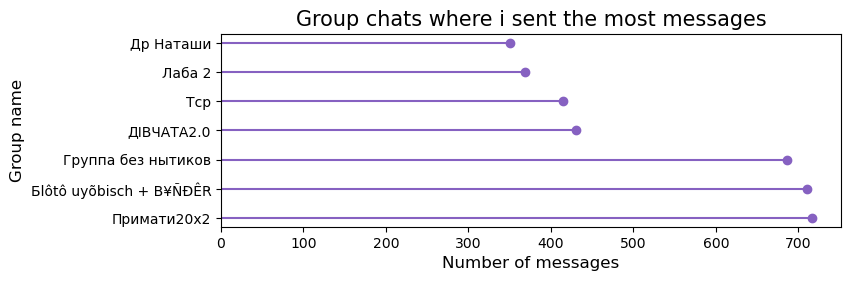

In [1279]:
plt.style.use('default')
fig, ax = plt.subplots(figsize=(8,2.5))
ax.hlines(groups_count['name'], xmin = 0, xmax = groups_count['message'], color = '#8661C1')
ax.plot(groups_count['message'], groups_count['name'], 'o', color = '#8661C1')
ax.set_xlim(0)
plt.title("Group chats where i sent the most messages", fontsize = 15)
plt.xlabel('Number of messages', fontsize =12)
plt.ylabel('Group name', fontsize =12)

### 6. Chats with the highest average number of sent messages per day/сhats with the highest average number of messages i sent per day

#### Continuing to analyze activity in chats: I decided to find chats with the highest activity of users by calculating the average number of messages sent to the chat during the period of active communication in it.

In [1129]:
def add_avg(df):
    df["date"] = pd.to_datetime(df["date"]).dt.date
    days_df = df.groupby(['name'], as_index = False)['date'].nunique()
    messages_df = df.groupby(['name'], as_index = False)['message'].count()
    df_merged = pd.merge(days_df, messages_df, on = 'name')
    avg = None
    df_merged['avg'] = avg
    for ind in df_merged.index:
        df_merged['avg']  = (df_merged['message'] / df_merged['date']).astype(int)
    df_merged.sort_values('avg', ascending = False, inplace = True)
    df_merged = df_merged.head(15)
    return df_merged

In [1145]:
chats = df_merged.copy()
chats_s = df_merged.loc[df_merged['from_id'] == 'PeerUser(user_id=544639169)']
chats_final = add_avg(chats)
chats_s_final = add_avg(chats_s)

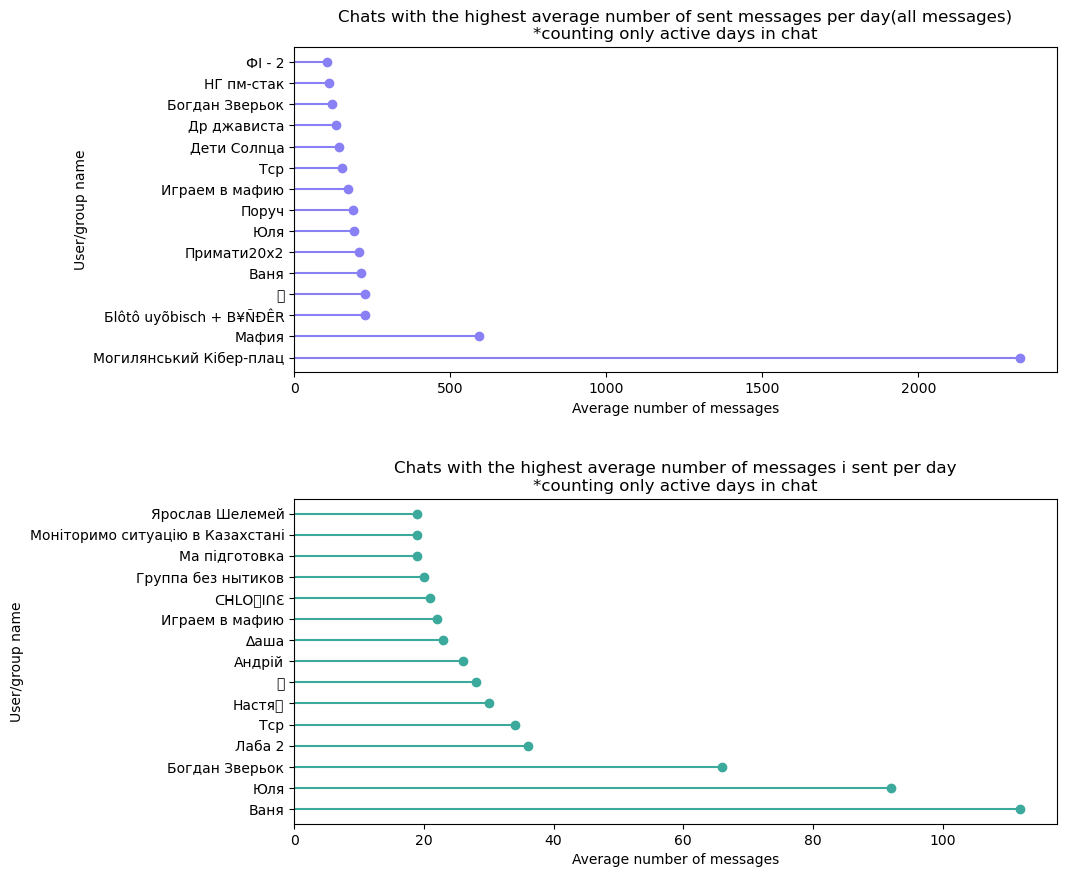

In [1153]:
fig,ax=plt.subplots(2,1,figsize=(10,10))
fig.tight_layout(pad = 7)
ax[0].hlines(chats_final['name'], xmin = 0, xmax = chats_final['avg'], color = '#8980F5')
ax[0].plot(chats_final['avg'], chats_final['name'], 'o', color = '#8980F5')
ax[0].set_xlim(0)
ax[0].set_title("Chats with the highest average number of sent messages per day(all messages)\n*counting only active days in chat", fontsize = 12)
ax[0].set_xlabel('Average number of messages', fontsize =10)
ax[0].set_ylabel('User/group name', fontsize =10)

ax[1].hlines(chats_s_final['name'], xmin = 0, xmax = chats_s_final['avg'], color = '#3BA99C')
ax[1].plot(chats_s_final['avg'], chats_s_final['name'], 'o', color = '#3BA99C')
ax[1].set_xlim(0)
ax[1].set_title("Chats with the highest average number of messages i sent per day\n*counting only active days in chat", fontsize = 12)
ax[1].set_xlabel('Average number of messages', fontsize =10)
ax[1].set_ylabel('User/group name', fontsize =10)

### 7. Stickers vs emojis

#### Using stickers and emojis is a good way to express your emotions. I looked at the change in the number of stickers and emojis I used, as well as the percentage of messages with stickers and emojis  to compare the amount of times i used them.

In [230]:
def emojis(text):
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            return True
    return False

In [1155]:
dfs = df.loc[(df['type'] == 'sticker') & (df['from_id']== 'PeerUser(user_id=544639169)')]
dfe = df.loc[(df['type'] == 'text') & (df['from_id']== 'PeerUser(user_id=544639169)')].assign(has_emoji = '-')

In [1156]:
for ind in dfe.index:
    text = str(dfe['message'][ind])
    if(emojis(text)):
        dfe['has_emoji'][ind] = '+'

In [1157]:
dfs["date"] = pd.to_datetime(dfs["date"]).dt.date
dfe["date"] = pd.to_datetime(dfe["date"]).dt.date
start = datetime.date(year=2020, month=7, day=1)
dfe = dfe.loc[(dfe['has_emoji'] == '+') & (dfe['date'] >= start)] 
dfs = dfs.loc[(dfs['date'] >= start)]

Text(0, 0.5, 'messages')

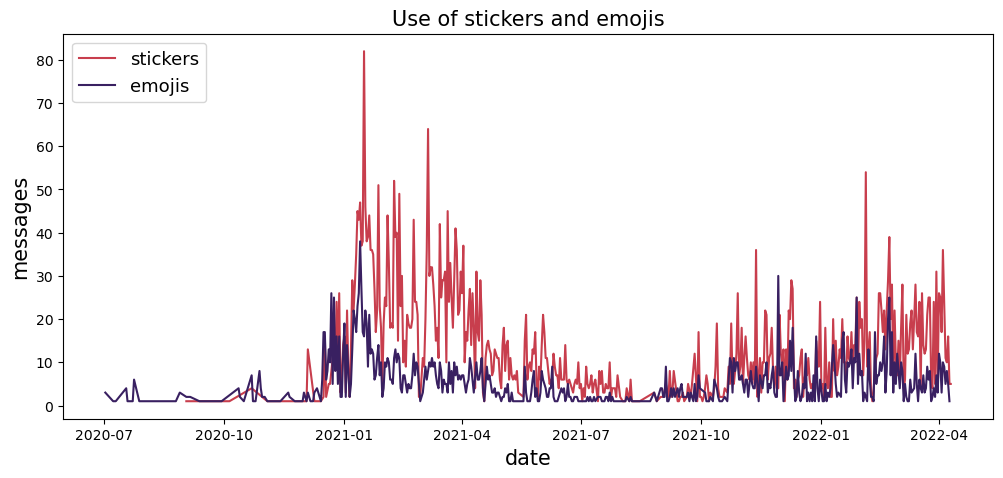

In [394]:
days_stickers = dfs["date"].value_counts()
days_emojis = dfe["date"].value_counts()
lines = days_stickers.plot.line(figsize = (12,5),color = "#C83E4D", label = 'stickers')
lines = days_emojis.plot.line(color = "#392061", label = "emojis")
lines.set_title('Use of stickers and emojis', fontsize = 15)
lines.set_xlabel("date", fontsize = 15) 
lines.legend(loc = "upper left", frameon = True, fontsize = 13)
lines.set_ylabel("messages", fontsize = 15)

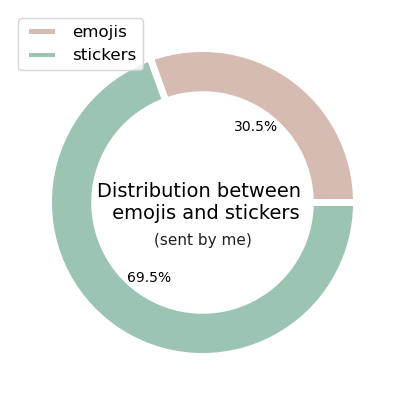

In [276]:
amount_emojis = dfe['has_emoji'].count()
amount_stickers = dfs['message'].count()
total = amount_emojis + amount_stickers
colors_se = ['#D5BBB1', '#9CC4B2']

fig, chart = plt.subplots(figsize=(5, 5))
pie3 = chart.pie([amount_emojis, amount_stickers], 
       startangle=0, colors = colors_se, autopct = "%1.1f%%", wedgeprops={'width':0.3, 'linewidth' : 5, 'edgecolor' : 'white' },)
plt.text(0, 0, "Distribution between \n emojis and stickers", ha='center', va='center', fontsize=14)
plt.text(0, -0.25, "(sent by me)", ha='center', va='center', fontsize = 11, color = '#212121')
plt.legend(['emojis', 'stickers'], loc="upper left", fontsize = 12)
plt.show()

### 8. My most used stickers

#### I think that stickers can reflect a person's mood and character very well, so I decided to look at the stickers I've been using lately. I usually use a very small set of stickers, so it was easy for me to match the code emoji to the actual sticker. I assume that most stickers will represent somewhat negative emotions.

In [366]:
df_last = df_merged.copy()
df_last['date'] = pd.to_datetime(df_last['date'])
df_last = df_merged.sort_values(by = 'date', ascending = False)
df_last = df_last.loc[df_last['from_id']== 'PeerUser(user_id=544639169)'].head(10000)
df_last = df_last.loc[(df_last['type_message'] == 'sticker')]
stickers_count = df_last.groupby(['message'])['message'].count().sort_values(ascending = False)

In [367]:
stickers_count.head(5)

message
😭       157
😳        95
🤷‍♀️     75
😵        48
😍        41
Name: message, dtype: int64

In [368]:
df_last.loc[df_last['message'] == '😭'].head()

,id,date,from_id,to_id,fwd_from,message,type_message,duration,dialog_id,name,type_dialog
107036,266869,2022-04-10 06:23:45+00:00,PeerUser(user_id=544639169),342667961,NaN,😭,sticker,NaN,342667961,Юля,Private dialog
107214,266622,2022-04-08 13:09:39+00:00,PeerUser(user_id=544639169),342667961,NaN,😭,sticker,NaN,342667961,Юля,Private dialog
107280,266556,2022-04-08 13:01:31+00:00,PeerUser(user_id=544639169),342667961,NaN,😭,sticker,NaN,342667961,Юля,Private dialog
107355,266479,2022-04-08 11:46:05+00:00,PeerUser(user_id=544639169),342667961,NaN,😭,sticker,NaN,342667961,Юля,Private dialog
107486,266338,2022-04-08 08:02:47+00:00,PeerUser(user_id=544639169),342667961,NaN,😭,sticker,NaN,342667961,Юля,Private dialog


In [369]:
df_last.loc[df_last['message'] == '😳'].head()

,id,date,from_id,to_id,fwd_from,message,type_message,duration,dialog_id,name,type_dialog
108418,265324,2022-04-05 16:12:23+00:00,PeerUser(user_id=544639169),342667961,NaN,😳,sticker,NaN,342667961,Юля,Private dialog
108442,265300,2022-04-05 16:02:32+00:00,PeerUser(user_id=544639169),342667961,NaN,😳,sticker,NaN,342667961,Юля,Private dialog
310305,265273,2022-04-05 12:54:12+00:00,PeerUser(user_id=544639169),384160793,NaN,😳,sticker,NaN,384160793,Ваня,Private dialog
108466,265237,2022-04-05 11:19:07+00:00,PeerUser(user_id=544639169),342667961,NaN,😳,sticker,NaN,342667961,Юля,Private dialog
108476,265227,2022-04-05 08:25:50+00:00,PeerUser(user_id=544639169),342667961,NaN,😳,sticker,NaN,342667961,Юля,Private dialog


In [370]:
df_last.loc[df_last['message'] == '🤷‍♀️'].head()

,id,date,from_id,to_id,fwd_from,message,type_message,duration,dialog_id,name,type_dialog
565717,3038,2022-04-09 16:14:09+00:00,PeerUser(user_id=544639169),PeerChannel(channel_id=1659062570),NaN,🤷‍♀️,sticker,NaN,-1001659062570,Группа без нытиков,Group
107866,265890,2022-04-06 13:23:22+00:00,PeerUser(user_id=544639169),342667961,NaN,🤷‍♀️,sticker,NaN,342667961,Юля,Private dialog
107902,265854,2022-04-06 11:40:38+00:00,PeerUser(user_id=544639169),342667961,NaN,🤷‍♀️,sticker,NaN,342667961,Юля,Private dialog
108134,265608,2022-04-05 21:33:00+00:00,PeerUser(user_id=544639169),342667961,NaN,🤷‍♀️,sticker,NaN,342667961,Юля,Private dialog
108220,265522,2022-04-05 20:18:37+00:00,PeerUser(user_id=544639169),342667961,NaN,🤷‍♀️,sticker,NaN,342667961,Юля,Private dialog


In [371]:
df_last.loc[df_last['message'] == '😵'].head()

,id,date,from_id,to_id,fwd_from,message,type_message,duration,dialog_id,name,type_dialog
107020,266887,2022-04-10 11:38:27+00:00,PeerUser(user_id=544639169),342667961,NaN,😵,sticker,NaN,342667961,Юля,Private dialog
107410,266420,2022-04-08 10:42:19+00:00,PeerUser(user_id=544639169),342667961,NaN,😵,sticker,NaN,342667961,Юля,Private dialog
107845,265915,2022-04-06 19:19:58+00:00,PeerUser(user_id=544639169),342667961,NaN,😵,sticker,NaN,342667961,Юля,Private dialog
107886,265870,2022-04-06 11:47:09+00:00,PeerUser(user_id=544639169),342667961,NaN,😵,sticker,NaN,342667961,Юля,Private dialog
107909,265847,2022-04-06 11:40:12+00:00,PeerUser(user_id=544639169),342667961,NaN,😵,sticker,NaN,342667961,Юля,Private dialog


In [372]:
df_last.loc[df_last['message'] == '😍'].head()

,id,date,from_id,to_id,fwd_from,message,type_message,duration,dialog_id,name,type_dialog
107034,266871,2022-04-10 06:23:56+00:00,PeerUser(user_id=544639169),342667961,NaN,😍,sticker,NaN,342667961,Юля,Private dialog
565709,3046,2022-04-09 16:15:40+00:00,PeerUser(user_id=544639169),PeerChannel(channel_id=1659062570),NaN,😍,sticker,NaN,-1001659062570,Группа без нытиков,Group
506043,266740,2022-04-09 12:09:35+00:00,PeerUser(user_id=544639169),373321078,NaN,😍,sticker,NaN,373321078,Настя💖,Private dialog
107284,266550,2022-04-08 11:51:34+00:00,PeerUser(user_id=544639169),342667961,NaN,😍,sticker,NaN,342667961,Юля,Private dialog
107398,266435,2022-04-08 10:45:18+00:00,PeerUser(user_id=544639169),342667961,NaN,😍,sticker,NaN,342667961,Юля,Private dialog


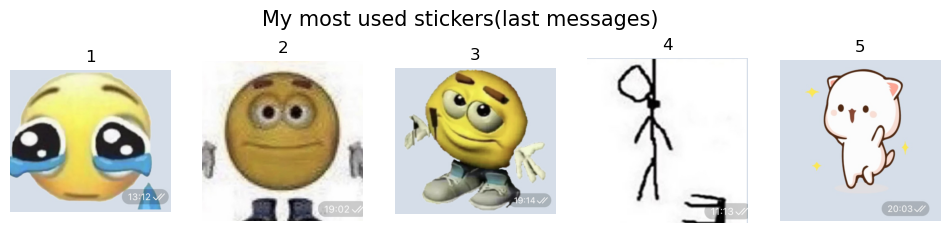

In [390]:
im1 = mpimg.imread('../stickers/1.jpg')
im2 = mpimg.imread('../stickers/2.jpg')
im3 = mpimg.imread('../stickers/3.jpg')
im4 = mpimg.imread('../stickers/4.jpg')
im5 = mpimg.imread('../stickers/5.jpg')
images = [im1, im2, im3, im4, im5]
fig = plt.figure(figsize = (12,2.7))
fig.suptitle('My most used stickers(last messages)', fontsize = 15)

for ind in range (0, len(images)):
    ax = fig.add_subplot(1,5,ind+1)
    ax.imshow(images[ind])
    ax.set_title(ind+1)
    ax.axis('off')

#### Result: indeed, most stickers are negative, which reflects my emotions nowadays.

### 9. Most used words

#### I tried to figure out which words I used the most by creating a small word cloud.

In [382]:
def readFile(fileName):
    fileObj = open(fileName, "r")
    words = fileObj. read(). splitlines()
    fileObj. close()
    return words

In [385]:
stopwords_ua = readFile('../words/stopwords_ua.txt')
stopwords_ru = readFile('../words/stopwords-ru.txt')

In [1206]:
def get_words(df):
    words = []
    for ind in df.index:
        for word in str(df['message'][ind]).split():
            word.replace(".","")
            if (word not in stopwords_ua) and (word not in stopwords_ru) and (word != 'nan') and (word.isalpha()) and (len(word)>2):
                words.append(word)
    return words

In [1211]:
words_s_df = df.loc[df['from_id'] == 'PeerUser(user_id=544639169)']
words_r_df = df.loc[df['to_id'] == '544639169']
words_s = get_words(words_s_df)
words_r = get_words(words_r_df)

In [389]:
def create_wordcloud(words, colormap):
    custom_mask = np.array(Image.open('../cloud2.png'))
    wordcount = pd.value_counts(np.array(words))
    wordcloud = WordCloud(colormap=colormap,
                      collocations = False, 
                      background_color="white", 
                      width=4000, 
                      height=3000, 
                      max_words=27,
                      min_font_size = 30,
                      max_font_size = 100,
                      mask = custom_mask).generate_from_frequencies(wordcount)
    return wordcloud

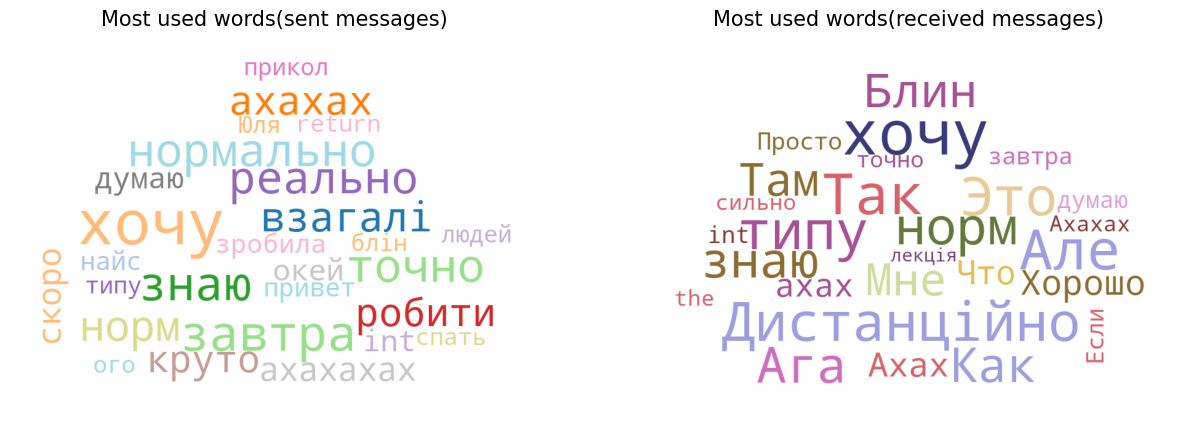

In [1252]:
wordcloud_s = create_wordcloud(words_s, 'tab20')
wordcloud_r = create_wordcloud(words_r, 'tab20b')
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(1,2,1)
ax.imshow(wordcloud_s)
ax.axis('off')
plt.title('Most used words(sent messages)', fontsize = 15)
ax = fig.add_subplot(1,2,2)
ax.axis('off')
plt.title('Most used words(received messages)', fontsize = 15)
ax.imshow(wordcloud_r)

### 10. Common vocabulary with users who i talked to the most in 2022

#### Here I have grouped some words most used by me and my two closest friends to see how many common words we use in communication.

In [1242]:
user1 = df.loc[(df['from_id'] == 'PeerUser(user_id=544639169)') & ((df['dialog_id'] == 373321078) | (df['dialog_id'] == 342667961))]
user2 = df.loc[(df['dialog_id'] == 373321078) &  (df['to_id'] == '544639169')]
user3 = df.loc[(df['dialog_id'] == 342667961) &  (df['to_id'] == '544639169')]

In [1243]:
words1 = get_words(user1)
words2 = get_words(user2)
words3 = get_words(user3)

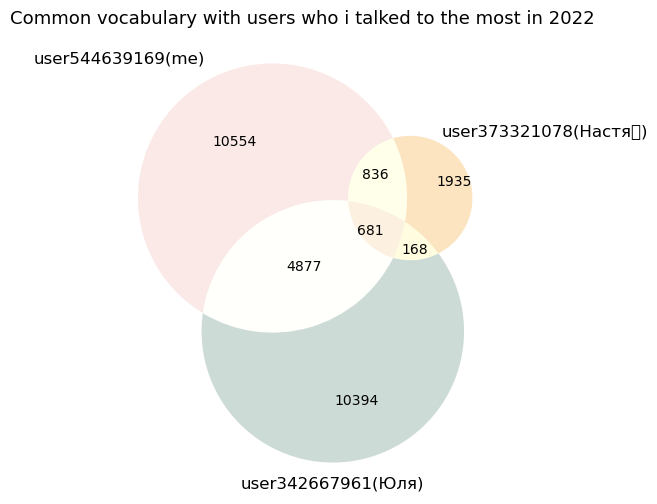

In [1249]:
set1 = set(words1)
set2 = set(words2)
set3 = set(words3)
fig = plt.figure(figsize=[6,6])
v = venn3([set1, set2, set3], ('user544639169(me)', 'user373321078(Настя💖)', 'user342667961(Юля)'), set_colors=("#f5cac3",
                             "#f6bd60", "#84a59d"))
plt.title("Common vocabulary with users who i talked to the most in 2022 ",fontsize = 13)
plt.show()

#### Conclusion: we do not have much in common lexicon since we speak different languages.

### 11. Users who have their phone numbers hidden

#### Many people are worried about the security of their data, so I decided to look at the number of people who have restricted access to their phone number.

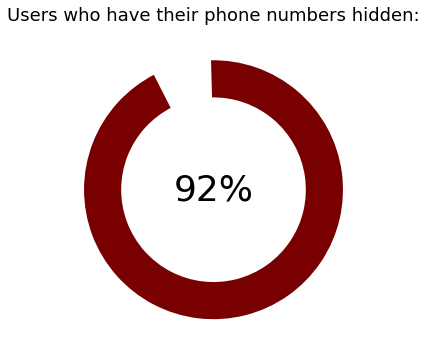

In [82]:
meta2 = df_meta.copy().drop_duplicates(subset = 'users', keep = 'first').reset_index()
meta2.drop_duplicates(subset = 'users', keep = 'first').reset_index()
unavailable = 0
for ind in meta2.index:
    res = meta2['users'][ind][-5:-1]
    if res == 'None':
        unavailable += 1;
total = meta2.shape[0]
available = total - unavailable
fig, ax = plt.subplots(figsize=(6, 6))
data = [unavailable, available]
percentage = int(unavailable/total*100)
wedgeprops = {'width':0.3, 'edgecolor':'white', 'lw':2}
patches, _ = ax.pie(data, wedgeprops=wedgeprops, startangle=117, colors=['#780000', 'white'])
patches[1].set_zorder(0)
patches[1].set_edgecolor('white')
plt.title('Users who have their phone numbers hidden:', fontsize=18, loc='center')
plt.text(0, 0, f"{percentage}%", ha='center', va='center', fontsize=36)
plt.show()

### 12. Groups/channels every year

#### My activity in telegram is directly related to the number of group chats and channels. I decided to look at how their number has changed over the years. This change can be related to the change of my circle of friends as well as other events in life. I also decided to look at the change in the number of channels since entering the university.

In [157]:
channels = df.loc[df['to_id'].str.contains('PeerChannel')]
groups = df.loc[df['to_id'].str.contains('PeerChat')]
groups['year'] = pd.DatetimeIndex(groups['date']).year
groups['month'] = pd.to_datetime(groups['date']).dt.strftime('%Y-%m') 
channels['year'] = pd.DatetimeIndex(channels['date']).year
channels['month'] = pd.to_datetime(channels['date']).dt.strftime('%Y-%m') 
channels_y = channels.groupby('year',as_index = False)['dialog_id'].nunique()
groups_y = groups.groupby('year',as_index = False)['dialog_id'].nunique()

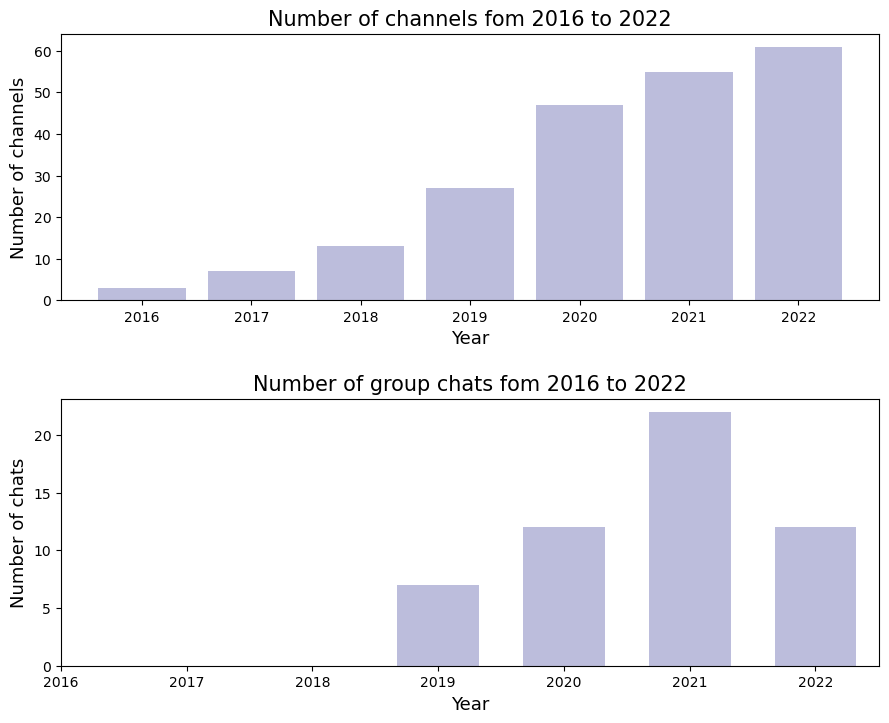

In [165]:
fig,ax=plt.subplots(2,1,figsize=(10,8))
fig.tight_layout(pad = 5)

ax[0].bar(channels_y['year'], channels_y['dialog_id'], color = '#bcbddc')
ax[0].set_title('Number of channels fom 2016 to 2022', fontsize = 15)
ax[0].set_xlabel('Year', fontsize = 13)
ax[0].set_ylabel('Number of channels', fontsize = 13)

ax[1].bar(groups_y['year'], groups_y['dialog_id'], color = '#bcbddc', width = 0.65)
ax[1].set_title('Number of group chats fom 2016 to 2022', fontsize = 15)
ax[1].set_xticks(range(2016,2023))
ax[1].set_xlabel('Year', fontsize = 13)
ax[1].set_ylabel('Number of chats', fontsize = 13)

In [103]:
start = datetime.date(year = 2020, month =8, day = 1)
channels['date'] = pd.to_datetime(channels["date"]).dt.date 
channels_m = channels.loc[channels['date'] > start]
channels_m = channels_m.groupby('month', as_index = False)['dialog_id'].nunique()

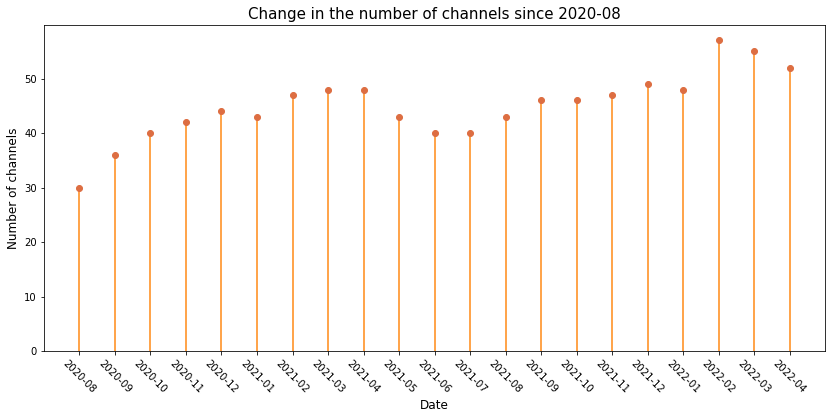

In [106]:
fig, ax = plt.subplots(figsize=(14,6))
ax.vlines(channels_m['month'], ymin = 0, ymax = channels_m['dialog_id'], color = '#ff8811')
ax.plot(channels_m['month'], channels_m['dialog_id'], 'o', color = '#dd6e42')
ax.set_ylim(0)
plt.xticks(channels_m['month'], rotation = -45)
plt.title("Change in the number of channels since 2020-08", fontsize = 15)
plt.xlabel('Date', fontsize =12)
plt.ylabel('Number of channels', fontsize =12)

#### Conclusions: we can see that the number of group chats has changed a lot in 2022, which I can explain by the fact that I stopped talking to a lot of my old friends. Unfortunately, I have not seen the expected changes in the number of channels since the beginning of autumn 2020, their number has only changed slightly since the beginning of the war.

### 13. Analysis of hourly activity

#### I counted the amount of messages sent every hour of the day to see when I was the most active. I also researched the change in activity hours over the years.

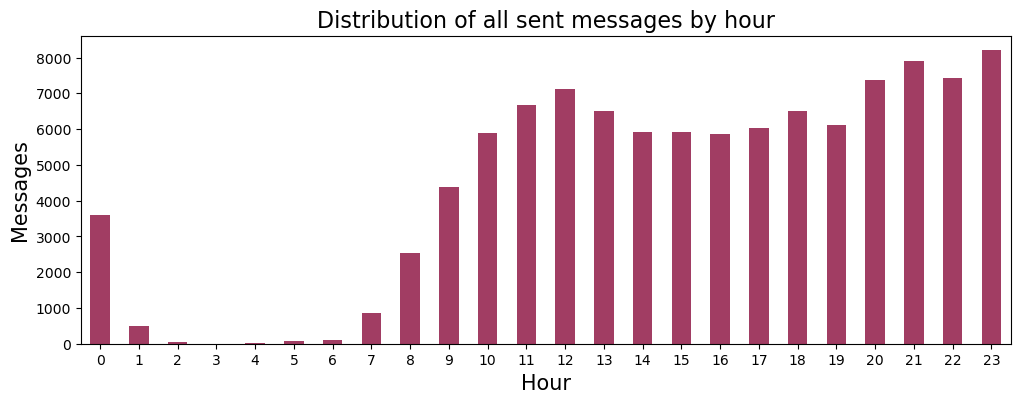

In [1197]:
sent_time = df.loc[df['from_id'] == 'PeerUser(user_id=544639169)']
sent_time['date'] = pd.to_datetime(sent_time['date'])
sent_time['hour'] = sent_time['date'].dt.hour
sent_time['hour'] = [(hour + 2)%24 for hour in sent_time['hour']]
time_num = sent_time.groupby('hour',as_index=False)['message'].count()
time_num.plot(kind = 'bar', stacked = True, color = ['#A13D63'], figsize = (12,4), legend = None)
plt.ylabel('Messages', fontsize = 15)
plt.xlabel('Hour', fontsize = 15)
plt.title('Distribution of all sent messages by hour', fontsize = 16)
plt.xticks(rotation = 0)
plt.show()

In [1182]:
def group_year(df, year):
    res = df.loc[df['year'] == year].groupby('hour',as_index=False)['message'].count()
    return res

In [1183]:
time_year = sent_time.copy()
time_year['year'] = pd.DatetimeIndex(time_year['date']).year
t2018 = group_year(time_year, 2018)
t2019 = group_year(time_year, 2019)
t2020 = group_year(time_year, 2020)
t2021 = group_year(time_year, 2021)
t2022 = group_year(time_year, 2022)

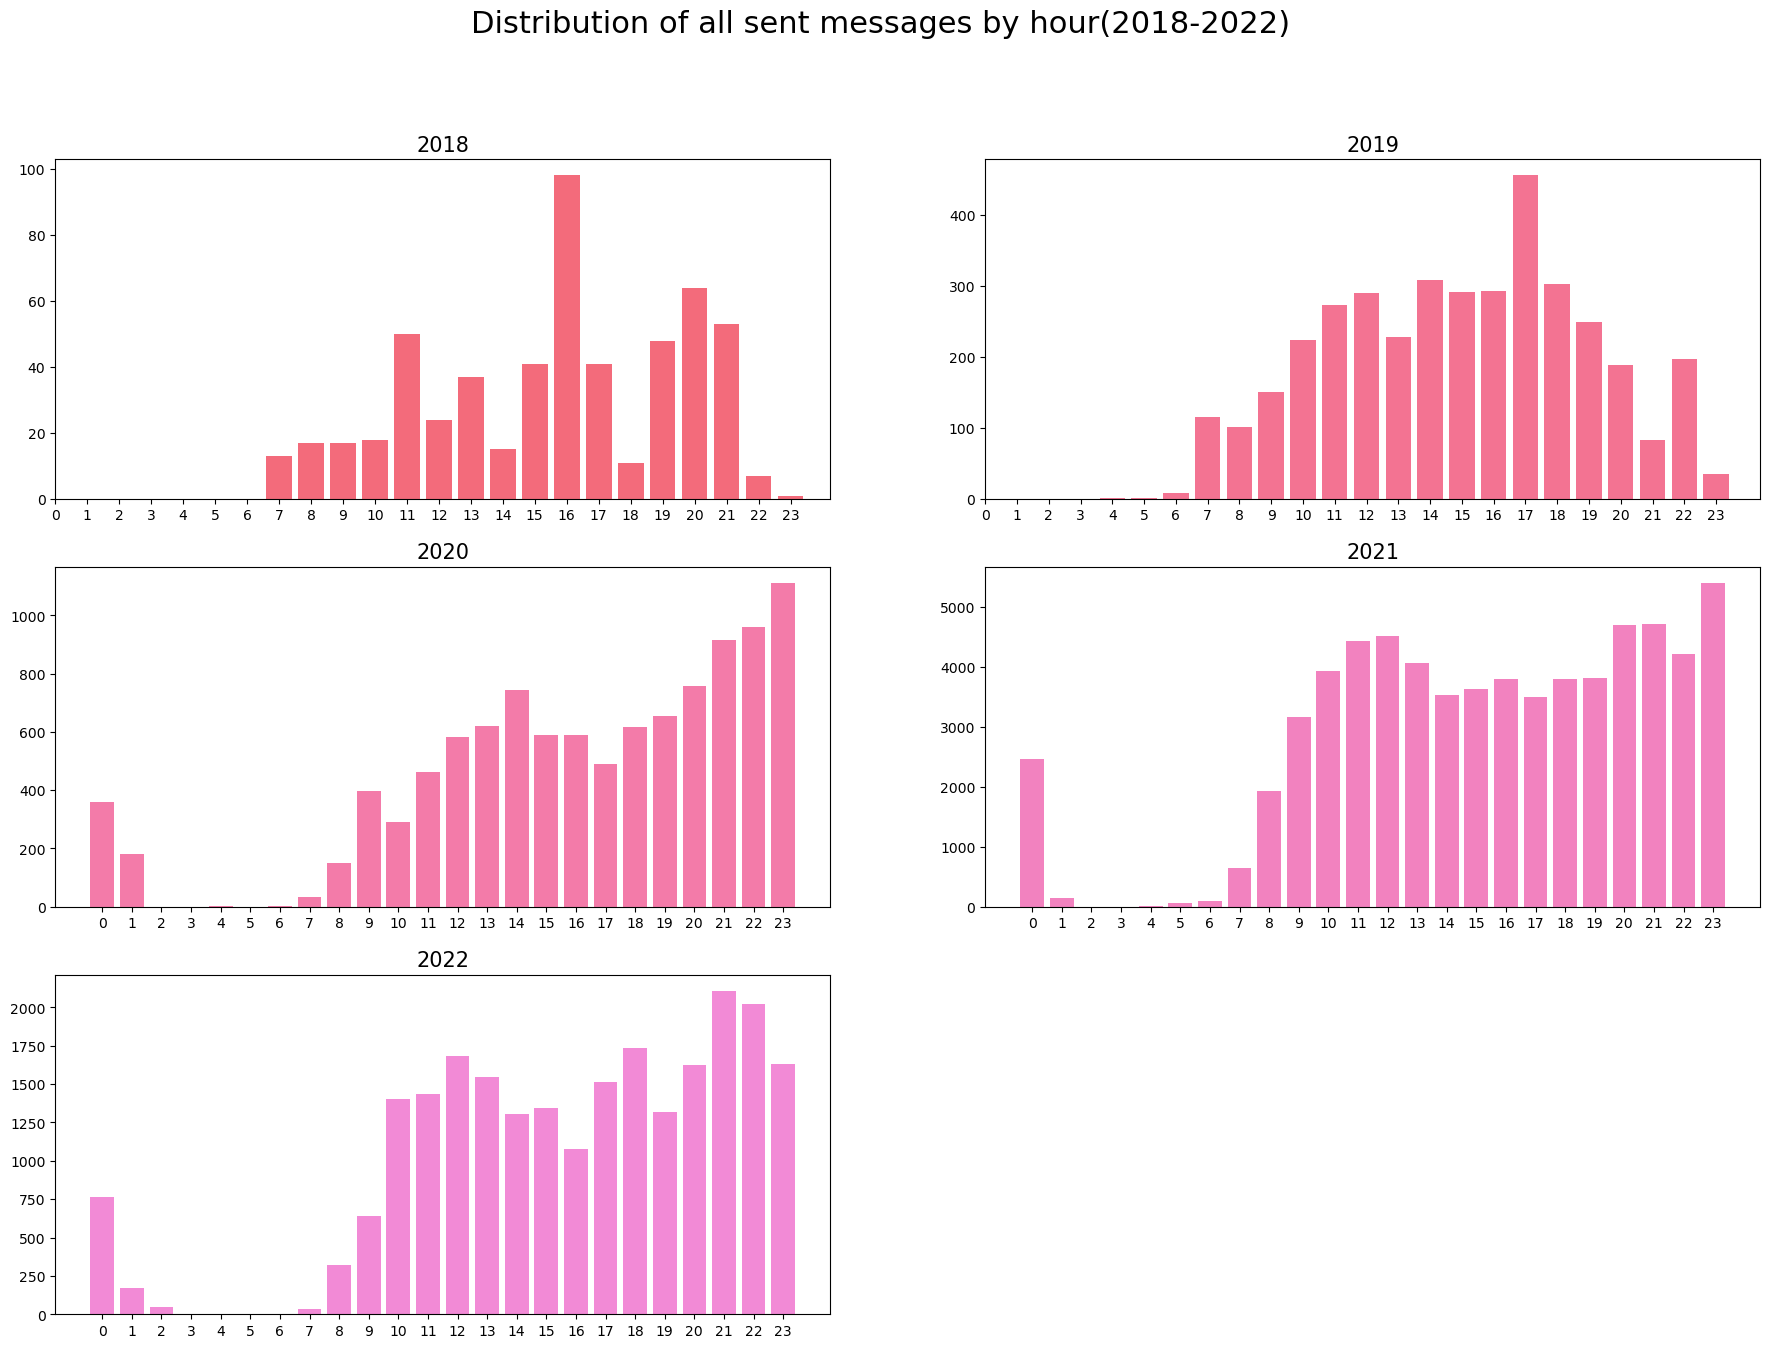

In [1198]:
fig,ax=plt.subplots(3,2,figsize=(22,15))
ax[2,1].set_visible(False)

ax[0,0].bar(t2018.hour ,t2018.message ,color = '#F36B7B' )
ax[0,0].set_title('2018', fontsize = 15)
ax[0,0].set_xticks(range(0,24,1))

ax[0,1].bar(t2019.hour ,t2019.message,color= '#F37392')
ax[0,1].set_title('2019', fontsize = 15)
ax[0,1].set_xticks(range(0,24,1))

ax[1,0].bar(t2020.hour ,t2020.message,color= '#F37BA9')
ax[1,0].set_title('2020', fontsize = 15)
ax[1,0].set_xticks(range(0,24,1))

ax[1,1].bar(t2021.hour ,t2021.message,color= '#F282BF')
ax[1,1].set_title('2021', fontsize = 15)
ax[1,1].set_xticks(range(0,24,1))

ax[2,0].bar(t2022.hour ,t2022.message,color= '#F28AD6')
ax[2,0].set_title('2022', fontsize = 15)
ax[2,0].set_xticks(range(0,24,1))

fig.suptitle('Distribution of all sent messages by hour(2018-2022)', fontsize = 22)

plt.show()

#### Сonclusion: my most active hours since 2020 are in the evening.

### 14. Number of messages, forwarded from channels

#### The number of forwarded messages can correlate with different occasions, so I decided to look at the change in their number over time.

In [256]:
df_fwd = df.loc[~df['fwd_from'].isnull()]
df_fwd = df_fwd.loc[df_fwd['fwd_from'].str.contains('PeerChannel')]
df_fwd["date"] = pd.to_datetime(df_fwd["date"]).dt.date
days_fwd = df_fwd["date"].value_counts()

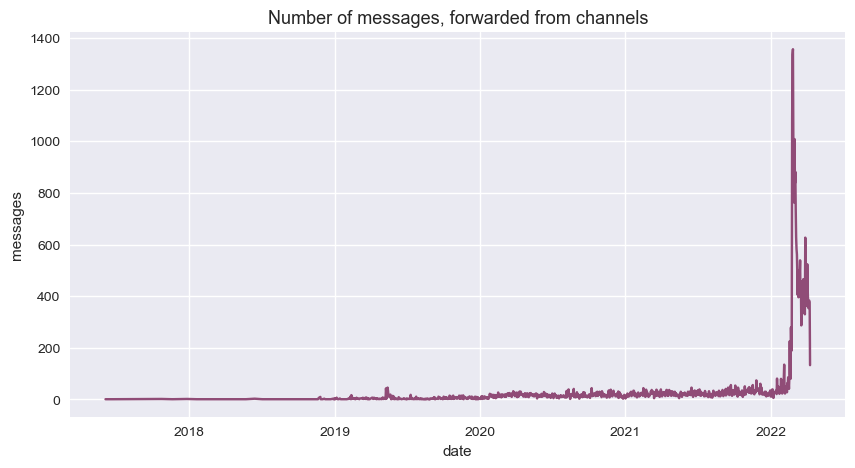

In [257]:
plt.style.use('seaborn')
f = days_fwd.plot.line(figsize = (10,5),color = "#904c77") 
f.set_title('Number of messages, forwarded from channels', fontsize = 13)
f.set_xlabel("date") 
f.set_ylabel("messages")

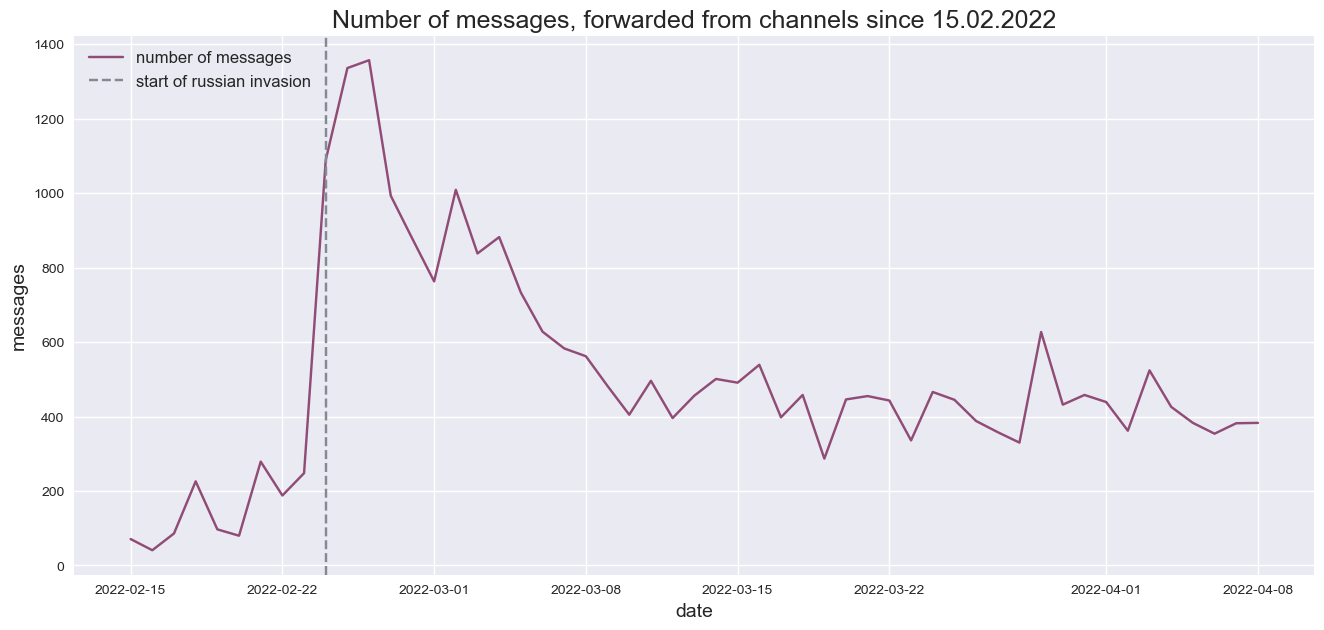

In [254]:
start = datetime.date(year = 2022, month = 2, day = 15)
end = datetime.date(year = 2022, month = 4, day = 8)
fwd_last = df_fwd.loc[(df_fwd['date'] >= start) & (df_fwd['date'] <= end)]
days_last = fwd_last["date"].value_counts()
f = days_last.plot.line(figsize = (16,7),color = "#904c77", label = 'number of messages') 
f.set_title('Number of messages, forwarded from channels since 15.02.2022', fontsize = 18)
f.set_xlabel("date", fontsize = 14) 
f.axvline(x = datetime.date(year = 2022, month = 2, day = 24), linestyle = '--', color = '#828A95', label = 'start of russian invasion')
f.legend(loc = "upper left", frameon = False, fontsize = 12)
f.set_ylabel("messages", fontsize = 14)

#### As we can see,  the number of such messages has changed drastically since the beginning of the war.

### 15. Weekly sentiment analysis

#### I decided to do some research on the impact on the sentiment of the message by the day and time when it was sent. I assume that the impact will be insignificant.

In [40]:
def calculate_msg_sentiment(msg, lang):
    if not isinstance(msg, str):
        return 0
    elif lang == "uk":
        tonality_dict = tonality_dict_ua
    elif lang == "ru":
        tonality_dict = tonality_dict_ru
    tokenized_msg = msg.split()
    overall_sentiment = 0
    words_num = 0
    for token in tokenized_msg:
        token_sentiment = tonality_dict.get(token.lower(), 0)
        if token_sentiment:
            overall_sentiment += token_sentiment
    words_num += 1
    avg_sentiment = overall_sentiment / words_num
    return avg_sentiment


def add_dialog_sentiment(data):
    data['msg_sentiment'] = data.apply(lambda x: calculate_msg_sentiment(x['message'], x['language']),axis=1)
    return data

def calculate_avg_subdialog_sentiment(data):
    grouped_data = sentiment_data_for_each_msg.groupby(
        [sentiment_data_for_each_msg['from_id'].fillna('-'),
         sentiment_data_for_each_msg['dialog_id']])
    data['avg_subdialog_sentiment'] = round(grouped_data['msg_sentiment'].transform(lambda x: x.mean()),3)
    return data

def calculate_dialog_sentiment(data):
    grouped_data = sentiment_data_for_each_msg.groupby(
         sentiment_data_for_each_msg['dialog_id'])
    data['avg_dialog_sentiment'] = round(grouped_data['msg_sentiment'].transform(lambda x: x.mean()),3)
    return data


def add_hour_and_dayoweek(data):
    data[['hour_of_day', 'day_of_week']] = data.apply(lambda x: get_day_and_hour(x['date']), axis=1,result_type="expand")
    return data

def analyze_sentiment_for_hour_and_dayoweek(data_with_hour_and_week):
    grouped_by_date = data_with_hour_and_week.groupby(['from_id', 'day_of_week', 'hour_of_day'])
    finalized_data = grouped_by_date['avg_dialog_sentiment'].mean().round(3).reset_index()
    return finalized_data

def analyze_sentiment_for_hour_and_dayoweek2(data_with_hour_and_week):
    grouped_by_date = data_with_hour_and_week.groupby(['from_id', 'day_of_week', 'hour_of_day'])
    finalized_data = grouped_by_date['avg_subdialog_sentiment'].mean().round(3).reset_index()
    return finalized_data

In [41]:
tonality_dict_ua = get_ua_tonality_dict_combined()
tonality_dict_ru = get_ru_tonality_dict()

In [ ]:
sentiment_data_for_each_msg = add_dialog_sentiment(df_lang_main)
dialog_sentiment_data = calculate_dialog_sentiment(sentiment_data_for_each_msg)
data_with_hour_and_week = add_hour_and_dayoweek(dialog_sentiment_data)
final_sentiment_data = analyze_sentiment_for_hour_and_dayoweek(data_with_hour_and_week)

In [644]:
subdialog_sentiment_data = calculate_avg_subdialog_sentiment(sentiment_data_for_each_msg)
data_with_hour_and_week_sub = add_hour_and_dayoweek(subdialog_sentiment_data)
final_sentiment_data_sub = analyze_sentiment_for_hour_and_dayoweek2(data_with_hour_and_week_sub)

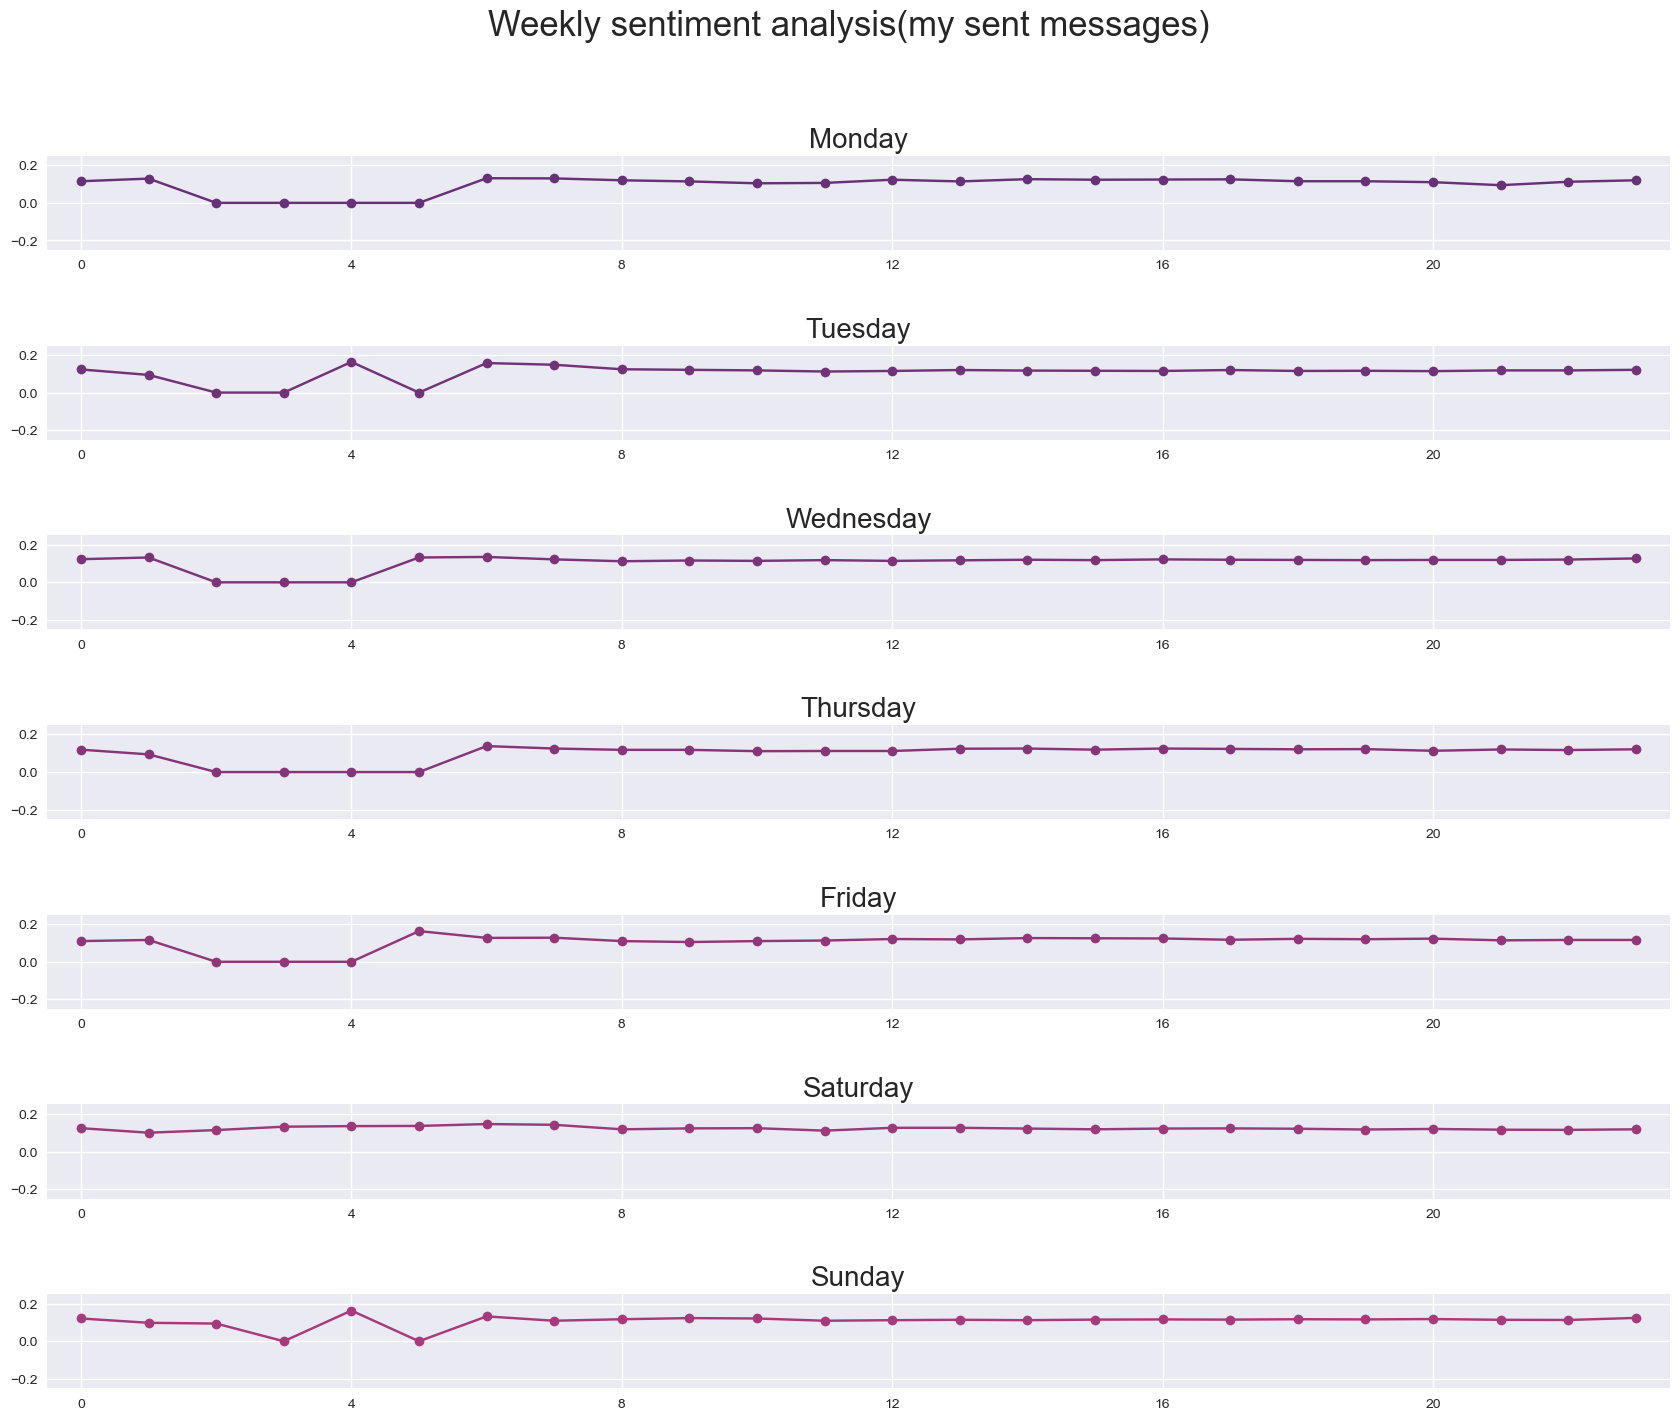

In [1265]:
user_sent_data = final_sentiment_data_sub[final_sentiment_data_sub['from_id'] == 'PeerUser(user_id=544639169)']
user_sent_data['hour_of_day'] = [(hour + 2)%24 for hour in user_sent_data['hour_of_day']]
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
fig,ax=plt.subplots(7,1,figsize=(18,15))
fig.suptitle('Weekly sentiment analysis(my sent messages)', fontsize = 25)
fig.tight_layout(pad = 5)
for day_of_week in range(1, 8):
    day_of_week_data = user_sent_data.query(f'day_of_week == {day_of_week}')
    hourly_data = dict(zip(day_of_week_data.hour_of_day, day_of_week_data.avg_subdialog_sentiment))
    hourly_data_dict = {hour : 0 for hour in range(24)}
    hourly_data_dict.update(hourly_data)
    ax[day_of_week-1].plot(list(hourly_data_dict.keys()), list(hourly_data_dict.values()),  marker='o', color = '#663177')
    ax[day_of_week-1].set_xlim([-0.5,23.5])
    ax[day_of_week-1].set_ylim([-0.25,0.25])
    ax[day_of_week-1].set_xticks(range(0,24,4))
    ax[day_of_week-1].set_title(days[day_of_week-1], fontsize = 20)

#### Counclusion: i was right with my assumption, i don't really see how days of the week affect the sentiment of my messages.

### 16. Monthly sentiment analysis

#### I assumed that the average sentiment of messages may depend on the month and season of year.

In [273]:
df_month = sentiment_data_for_each_msg.loc[sentiment_data_for_each_msg['from_id'] == 'PeerUser(user_id=544639169)']
df_month['month'] = pd.to_datetime(df_month['date']).dt.strftime('%m') 
df_month = df_month.groupby('month')['msg_sentiment'].mean()

df_month_all = sentiment_data_for_each_msg.copy()
df_month_all['month'] = pd.to_datetime(df_month_all['date']).dt.strftime('%m') 
df_month_all = df_month_all.groupby('month')['msg_sentiment'].mean()

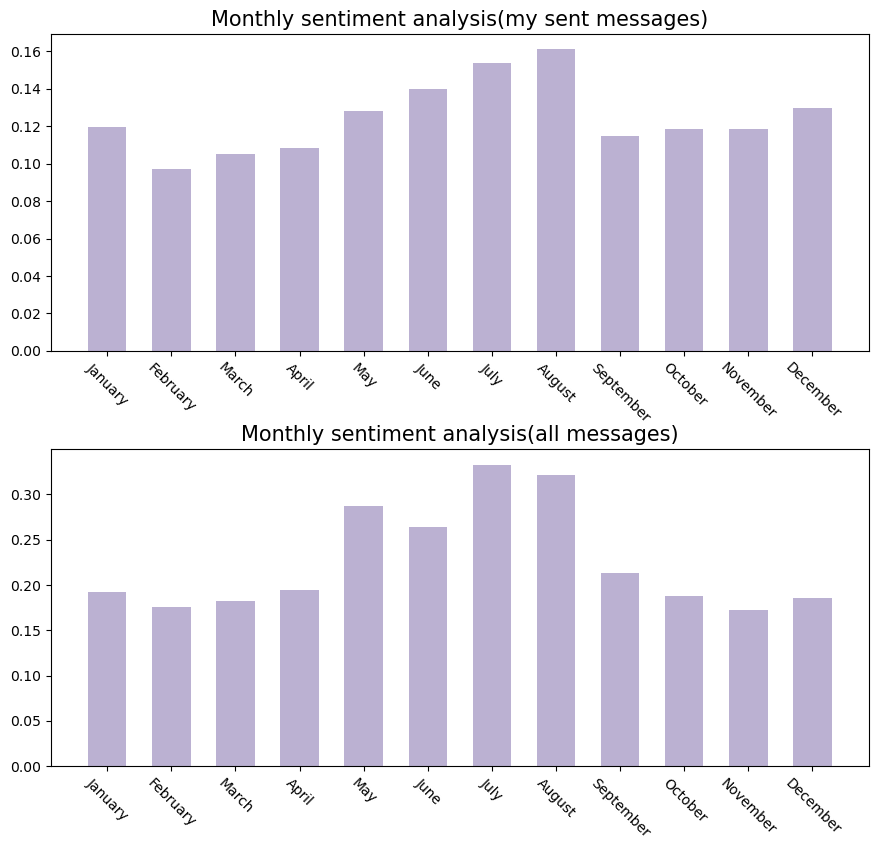

In [365]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 
          'November', 'December']
fig,ax=plt.subplots(2,1,figsize=(10,9))
fig.tight_layout(pad = 5)
plt.style.use('default')
ax[0].bar(list(df_month.keys()), list(df_month), color = '#BBB1D2', width = 0.6)
ax[0].set_title('Monthly sentiment analysis(my sent messages)', fontsize = 15)
ax[0].set_xticklabels(months, rotation = -45)

ax[1].bar(list(df_month_all.keys()), list(df_month_all), color = '#BBB1D2', width = 0.6)
ax[1].set_title('Monthly sentiment analysis(all messages)', fontsize = 15)
ax[1].set_xticklabels(months, rotation = -45)

#### Conclusion: the average sentiment value of messages is actually higher in may (end of exams) and in summer (summer vacation). Therefore we can say that time of year can actually affect the sentiment value.

### 17. 5 chats with the most messages and their average sentiment and average sentiment of some private chats

#### I also wanted to do some research on the average sentiment of messages in different chats.

In [10]:
top5 = df[(df.dialog_id <0)].groupby(["dialog_id"])["message"].count().sort_values(ascending = False).head(6)
groups = list(top5.keys())
top5 = data_with_hour_and_week.loc[data_with_hour_and_week['dialog_id'].isin(groups)]
top5_final = top5.drop_duplicates(subset = 'dialog_id', keep = 'first')
m2 = df_meta.drop_duplicates(subset = 'dialog_id', keep = 'first')
top5_final = pd.merge(top5_final, m2, on = 'dialog_id').sort_values('avg_dialog_sentiment', ascending = True)

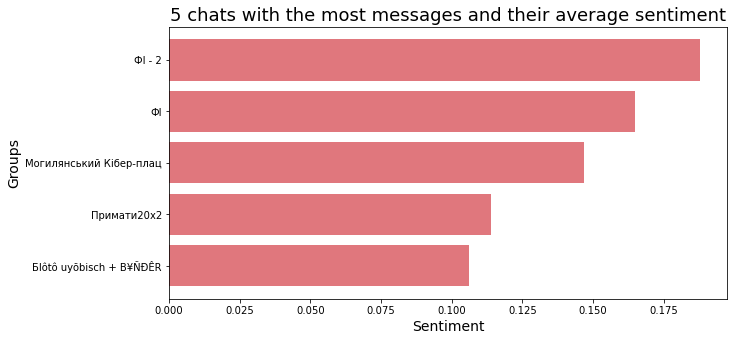

In [15]:
plt.rcParams['figure.figsize'] = (10,5)
plt.barh(top5_final['name'], top5_final['avg_dialog_sentiment'], color = '#E0777D')
plt.title('5 chats with the most messages and their average sentiment', fontsize = 18)
plt.xlabel("Sentiment", fontsize = 14)
plt.ylabel("Groups", fontsize = 14)

In [16]:
top10 = df[(df.to_id == "544639169")&(df.dialog_id >0)].groupby(["dialog_id"])["message"].count().sort_values(ascending = False).head(11)
users = list(top10.keys())

In [19]:
top10_users = data_with_hour_and_week.loc[data_with_hour_and_week['dialog_id'].isin(users)]
top10_users = top10_users.drop_duplicates(subset = 'dialog_id', keep = 'first')
top10_users = pd.merge(top10_users, df_meta, on = 'dialog_id').sort_values('avg_dialog_sentiment', ascending = True)

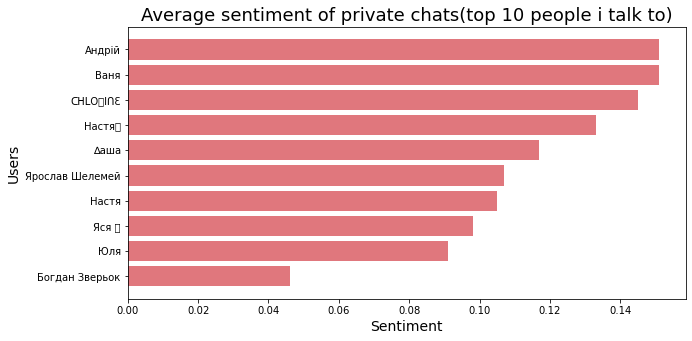

In [23]:
plt.rcParams['figure.figsize'] = (10,5)
plt.barh(top10_users['name'], top10_users['avg_dialog_sentiment'], color = '#E0777D')
plt.title('Average sentiment of private chats(top 10 people i talk to)', fontsize = 18)
plt.xlabel("Sentiment", fontsize = 14)
plt.ylabel("Users", fontsize = 14)

### 18. Chats with the highest/lowest average sentiment value

In [24]:
highest10 = data_with_hour_and_week.loc[data_with_hour_and_week['dialog_id']>0].drop_duplicates(subset = 'dialog_id', keep = 'first')
highest10 = highest10.sort_values('avg_dialog_sentiment', ascending = False).head(12)
highest10 = pd.merge(highest10, m2, on = 'dialog_id')
lowest10 = data_with_hour_and_week.loc[data_with_hour_and_week['dialog_id']>0].drop_duplicates(subset = 'dialog_id', keep = 'first')
lowest10 = lowest10.sort_values('avg_dialog_sentiment', ascending = True).head(10)
lowest10.loc[lowest10['avg_dialog_sentiment'] == 0, 'avg_dialog_sentiment'] = -0.0005
lowest10 = pd.merge(lowest10, m2, on = 'dialog_id')

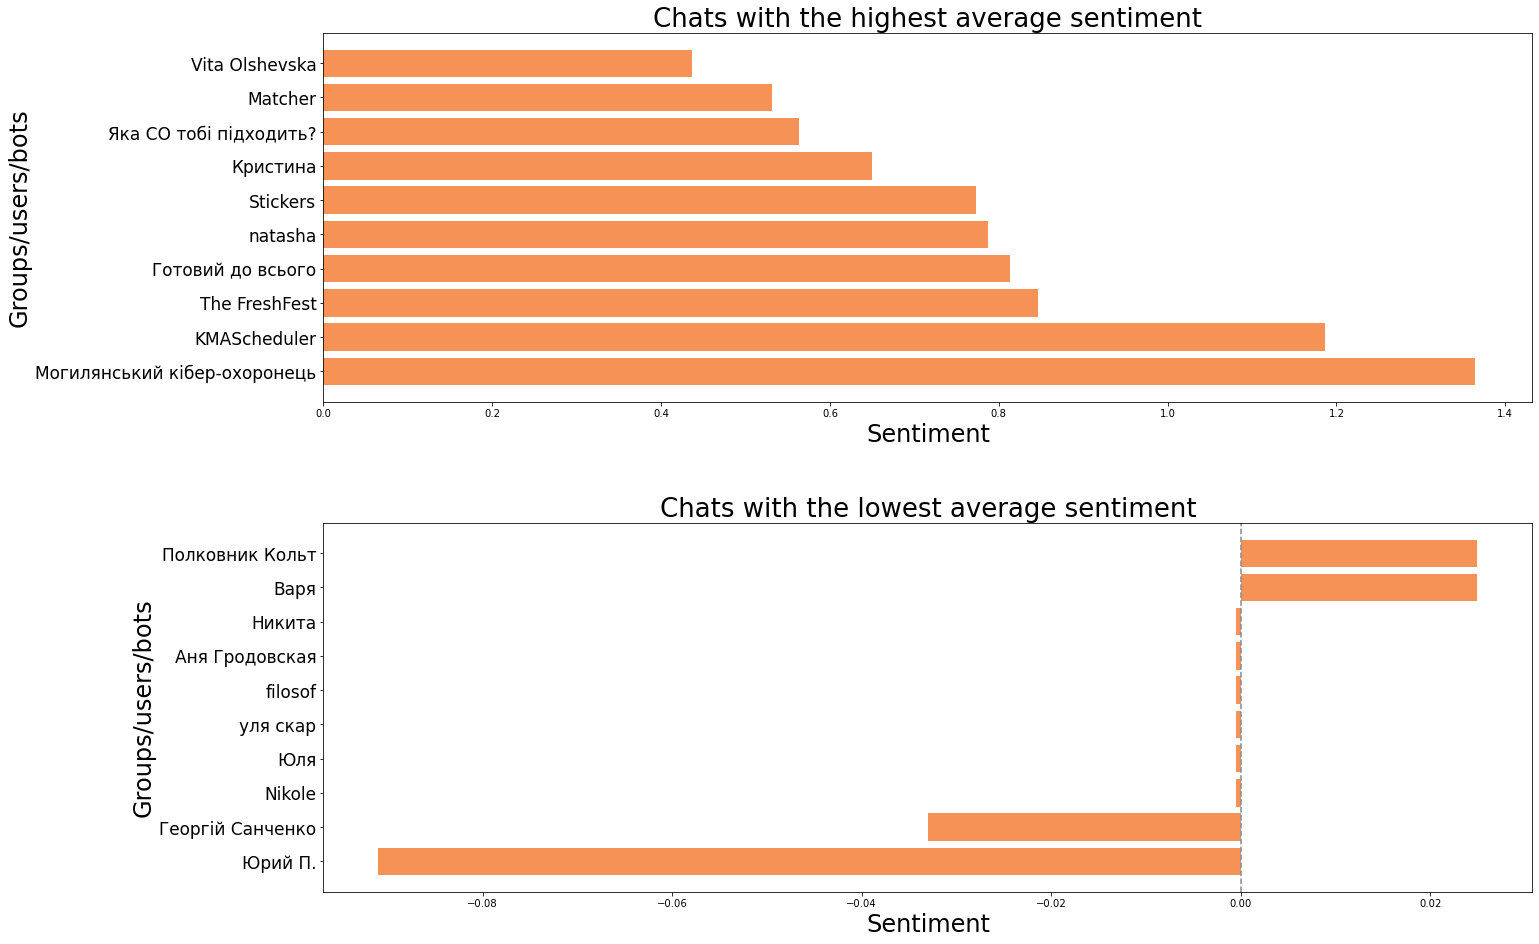

In [26]:
fig,ax=plt.subplots(2,1,figsize=(20,15))
fig.tight_layout(pad = 10)

ax[0].barh(highest10['name'], highest10['avg_dialog_sentiment'], color = '#F79256')
ax[0].set_title('Chats with the highest average sentiment', fontsize = 26)
ax[0].set_yticklabels(labels = highest10['name'],fontsize = 17)
ax[0].set_xlabel('Sentiment', fontsize = 24)
ax[0].set_ylabel('Groups/users/bots', fontsize = 24)

ax[1].barh(lowest10['name'], lowest10['avg_dialog_sentiment'], color = '#F79256')
ax[1].set_title('Chats with the lowest average sentiment', fontsize = 26)
ax[1].set_yticklabels(labels = lowest10['name'],fontsize = 17)
ax[1].axvline(x = 0, linestyle = '--', color = '#828A95')
ax[1].set_xlabel('Sentiment', fontsize = 24)
ax[1].set_ylabel('Groups/users/bots', fontsize = 24)

### 19. Change of daily average sentiment

#### I  looked at how the sentiment of messages changed depending on the events in my life. The first chart is very generalized, the second one is more detailed with the specification of certain important events.

In [666]:
sentiment_data_for_each_msg['date'] = pd.to_datetime(sentiment_data_for_each_msg["date"]).dt.date
start = datetime.date(year = 2022, month =1, day = 1)
sent1 = sentiment_data_for_each_msg.loc[sentiment_data_for_each_msg["date"]>start]
sent1 = sent1.groupby('date')['msg_sentiment'].mean()

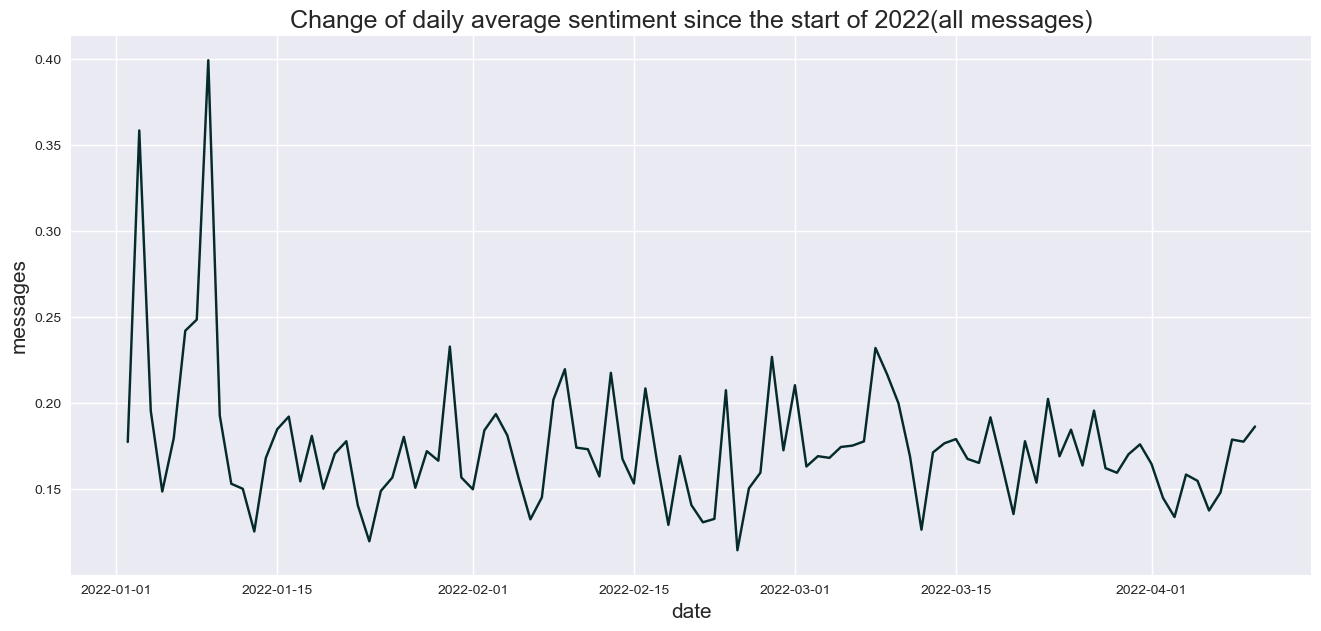

In [1167]:
sentiment_lines = sent1.plot.line(figsize = (16,7),color = "#042a2b") 
sentiment_lines.set_title('Change of daily average sentiment since the start of 2022(all messages)', fontsize = 18)
sentiment_lines.set_xlabel("date", fontsize = 15) 
sentiment_lines.set_ylabel("messages", fontsize = 15)
plt.style.use('seaborn')

In [675]:
start = datetime.date(year = 2021, month =9, day = 1)
sent2 = sentiment_data_for_each_msg.loc[(sentiment_data_for_each_msg['date']>start) & (sentiment_data_for_each_msg['dialog_id']== 342667961)]
sent2 = sent2.groupby('date')['msg_sentiment'].mean()

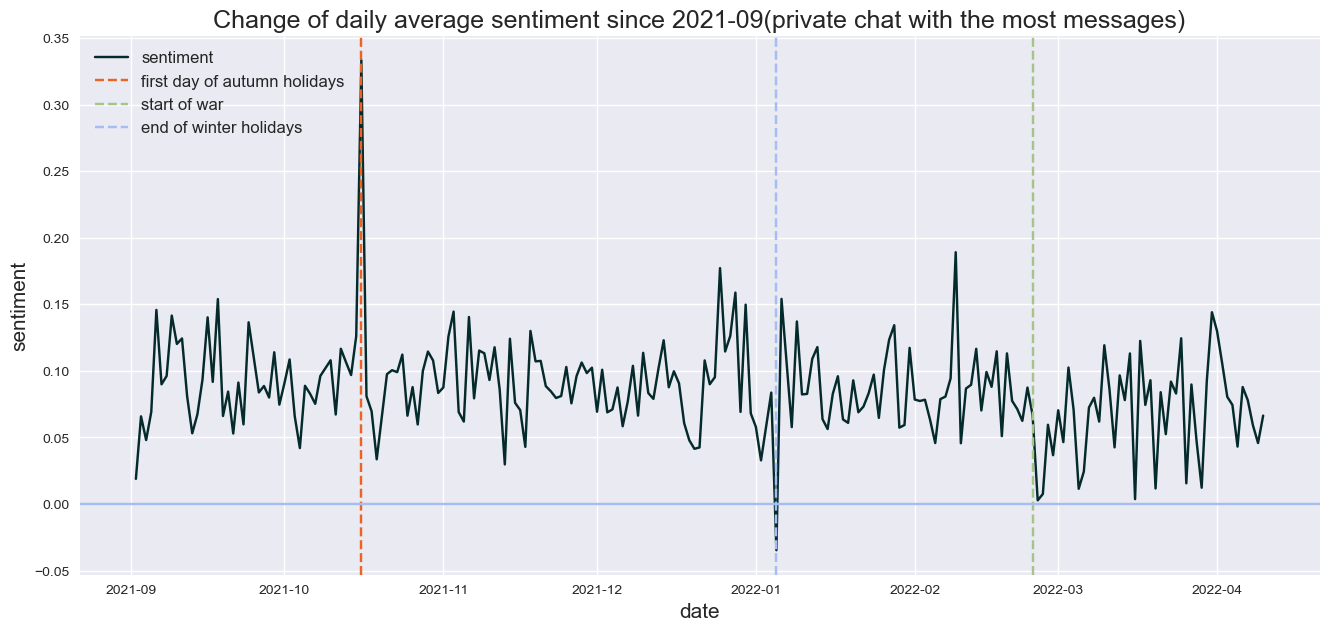

In [1168]:
lines2 = sent2.plot.line(figsize = (16,7),color = "#042a2b", label = 'sentiment') 
plt.style.use('seaborn')
lines2.set_title('Change of daily average sentiment since 2021-09(private chat with the most messages)', fontsize = 18)
lines2.axvline(x = datetime.date(year = 2021, month = 10, day = 16), linestyle = '--', color = '#eb6424', label = 'first day of autumn holidays')
lines2.axvline(x = datetime.date(year = 2022, month = 2, day = 24), linestyle = '--', color = '#a6c48a', label = 'start of war')
lines2.axvline(x = datetime.date(year = 2022, month = 1, day = 5), linestyle = '--', color = '#a4bef3', label = 'end of winter holidays')
lines2.axhline(y=0, linestyle = '-', color = '#a4bef3')
lines2.set_xlabel("date", fontsize = 15) 
lines2.legend(loc = 'upper left', fontsize = 12)
lines2.set_ylabel('sentiment', fontsize = 15)

#### In the second chart you can see that negative and positive events affect the sentiment of messages respectively.

### 20. Most used words in messages with highest and lowest sentiment values

#### I decided to do word clouds with words used in messages with highest and lowest sentiment values to see which words affected those values.

In [1256]:
max20 = sentiment_data_for_each_msg.sort_values('msg_sentiment', ascending = False).head(1000)
min20 = sentiment_data_for_each_msg.sort_values('msg_sentiment', ascending = True).head(1000)
words_max20 = get_words(max20)
words_min20 = get_words(min20)

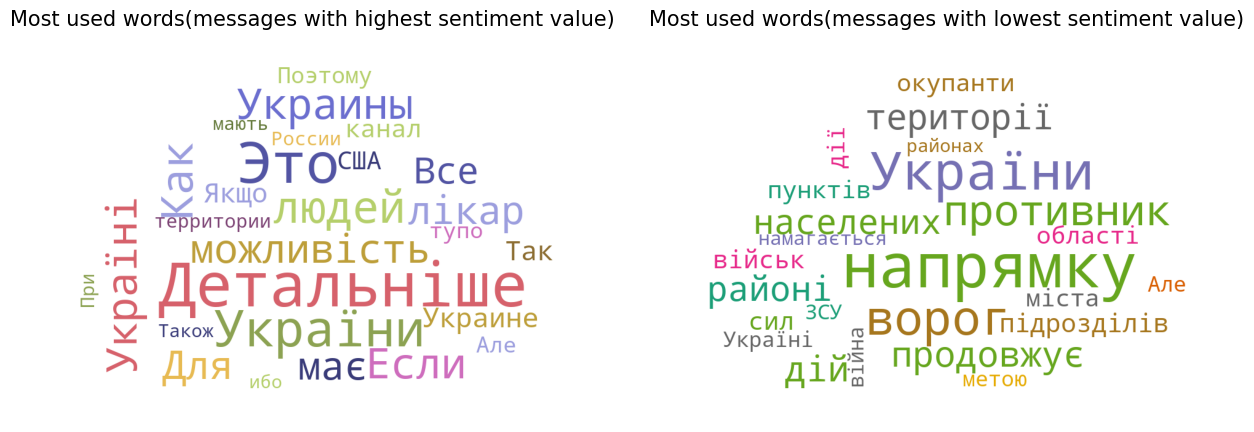

In [1257]:
wordcloud_max = create_wordcloud(words_max20, 'tab20b')
wordcloud_min = create_wordcloud(words_min20, 'Dark2')
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(1,2,1)
ax.imshow(wordcloud_max)
ax.axis('off')
plt.title('Most used words(messages with highest sentiment value)', fontsize = 15)
ax = fig.add_subplot(1,2,2)
ax.axis('off')
plt.title('Most used words(messages with lowest sentiment value)', fontsize = 15)
ax.imshow(wordcloud_min)

### 21. Influence of weather conditions on the average sentiment value

#### Unfortunately, I was only able to find a very small dataset for this research, which negatively affected the accuracy of the result, ie this chart can not provide accurate data. I left this it in my report just to demonstrate the idea and its implementation.
#### Update: i found a bigger dataset and used it for my second chart, which can actually provide some imteresting data.
#### Assumption: the warmer the day - the higher the sentiment value.

In [172]:
saved_sentiment = pd.read_csv('/Users/natashayandola/Desktop/sentiment.csv')
df_weather = pd.read_csv('/Users/natashayandola/Desktop/words/daily_weather_2020.csv')

In [173]:
saved_sentiment_s = saved_sentiment.loc[saved_sentiment['from_id']== 'PeerUser(user_id=544639169)']
weather_ukr = df_weather.loc[df_weather['Country/Region']=='Ukraine']
weather_ukr.rename(columns = {'time':'date'}, inplace = True)
weather_merged = pd.merge(saved_sentiment_s, weather_ukr, on = 'date')
weather_merged = weather_merged.groupby('icon', as_index = False)['msg_sentiment'].mean().sort_values('msg_sentiment', ascending = True)

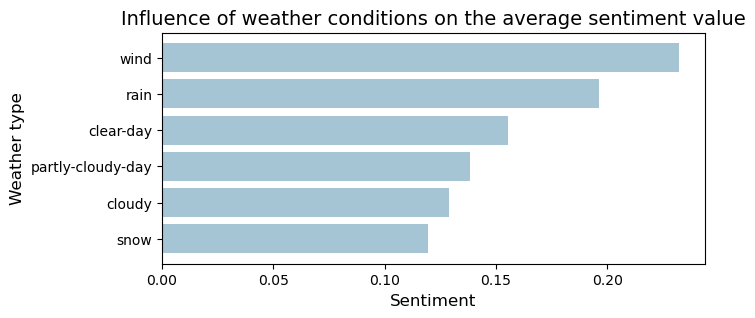

In [168]:
plt.rcParams['figure.figsize'] = (7,3)
plt.barh(weather_merged['icon'], weather_merged['msg_sentiment'], color = '#A5C4D4')
plt.title('Influence of weather conditions on the average sentiment value', fontsize = 14)
plt.xlabel("Sentiment", fontsize = 12)
plt.ylabel("Weather type", fontsize = 12)

In [145]:
df_weather_d = pd.read_csv('/Users/natashayandola/Desktop/weather/newdata2.csv', sep = ';')
df_weather_d['date'] = pd.to_datetime(df_weather_d["date"], yearfirst = True, dayfirst = False, format = '%d.%m.%Y').dt.date
df_weather_d['temperature'] = df_weather_d['temperature'].round(0)
df_weather_d.date = df_weather_d.date.astype(str)
df_weather_d = pd.merge(saved_sentiment_s, df_weather_d, on = 'date')
df_weather_d = df_weather_d.groupby('temperature', as_index = False)['msg_sentiment'].mean().sort_values('temperature', ascending = True)

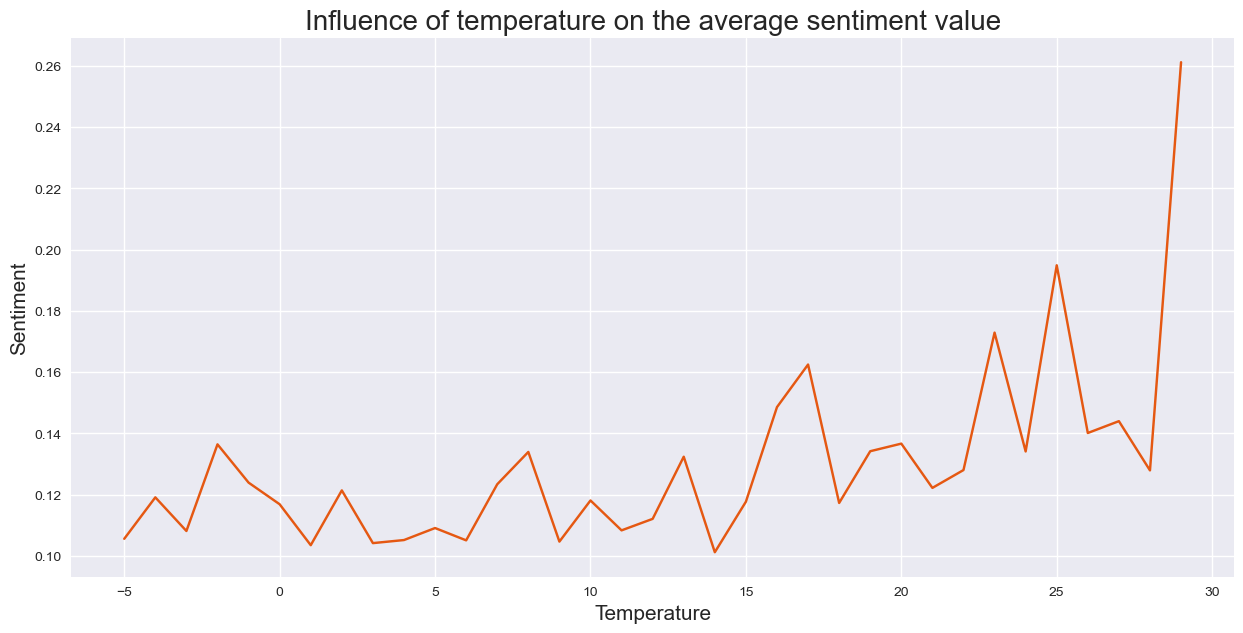

In [269]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15,7)
plt.plot(df_weather_d['temperature'], df_weather_d['msg_sentiment'], color = '#E55812')
plt.title('Influence of temperature on the average sentiment value', fontsize = 20)
plt.xlabel('Temperature', fontsize = 15)
plt.ylabel('Sentiment', fontsize = 15)

#### Result: we can trace the change in sentiment value in a positive direction along with how the air temperature goes up.

### 22. Distribution between genders(classified by names)

#### I tried to see if i have more male or female friends. 

In [388]:
female_ukr_names = pd.read_csv('../telegram-dialogs-analysis-v2-main/dicts/female_ukrainian_names.csv')
male_ukr_names = pd.read_csv('../telegram-dialogs-analysis-v2-main/dicts/male_ukrainian_names.csv')
female_ru_names = pd.read_csv('../telegram-dialogs-analysis-v2-main/dicts/female_russian_names.csv')
male_ru_names = pd.read_csv('../telegram-dialogs-analysis-v2-main/dicts/male_russian_names.csv')
female_ru_ukr_trans_names = pd.read_csv('../telegram-dialogs-analysis-v2-main/dicts/female_ru_ukr_trans_names.csv')
male_ru_ukr_trans_names = pd.read_csv('../telegram-dialogs-analysis-v2-main/dicts/male_ru_ukr_trans_names.csv')
female_ukr_names = list(female_ukr_names['name'])
male_ukr_names = list(male_ukr_names['name'])
female_ru_names = list(female_ru_names['name'])
male_ru_names = list(male_ru_names['name'])
female_ru_ukr_trans_names = list(female_ru_ukr_trans_names['name'])
male_ru_ukr_trans_names = list(male_ru_ukr_trans_names['name'])

In [264]:
def add_gender(df):
    for ind in df.index:
        first_name = df['name'][ind].strip().split()[0].lower()
        if (first_name in male_ukr_names) or (first_name in male_ru_names) or (first_name in male_ru_ukr_trans_names):
            df['gender'][ind] = 'male'
        elif (first_name in female_ukr_names) or (first_name in female_ru_names) or (first_name in female_ru_ukr_trans_names):
            df['gender'][ind] = 'female'

In [265]:
meta_users = df_meta.loc[df_meta['type']=='Private dialog'].assign(gender = 'unknown')
add_gender(meta_users)
meta_users_final = meta_users.groupby('gender')['gender'].count()

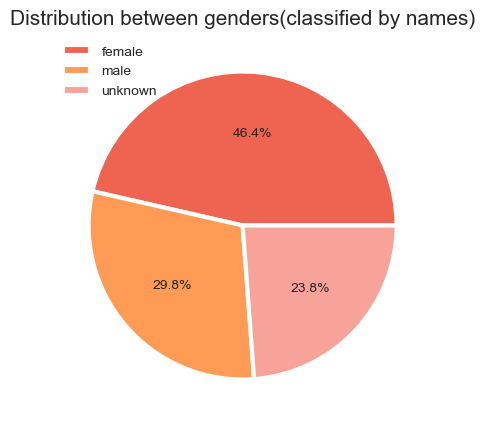

In [267]:
plt.rcParams['figure.figsize'] = (5,5)
genders = ['#ef6351', '#ff9b54', '#f7a399']
plt.title('Distribution between genders(classified by names)', fontsize = 15)
plt.pie(list(meta_users_final), labeldistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' }, autopct = "%1.1f%%", colors = genders)
plt.legend(labels=list(meta_users_final.keys()), loc = 'upper left', fontsize = 10)

#### Result: i have more female friends than male.

### 23. Distribution between types of sent/recieved messages by gender

In [338]:
messages_g = df_merged.loc[df_merged['dialog_id']>0]
meta_users = meta_users.loc[meta_users['gender'] != 'unknown']
messages_g = pd.merge(messages_g, meta_users, on = 'dialog_id')
mg_sent = messages_g.loc[messages_g['from_id'] == 'PeerUser(user_id=544639169)']
tab_gender_sent = pd.crosstab(index = mg_sent['type_message'], columns = mg_sent['gender'], normalize = 'index')
mg_rec = messages_g.loc[messages_g['from_id'] != 'PeerUser(user_id=544639169)']
tab_gender_rec = pd.crosstab(index = mg_rec['type_message'], columns = mg_rec['gender'], normalize = 'index')

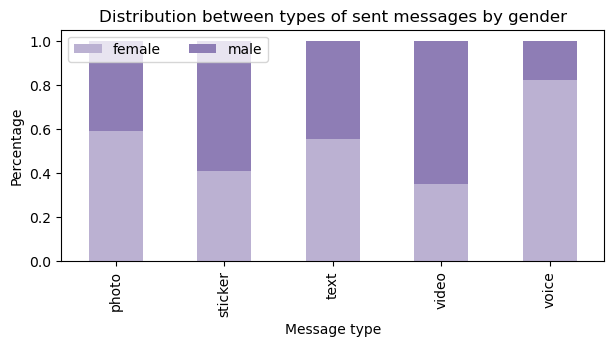

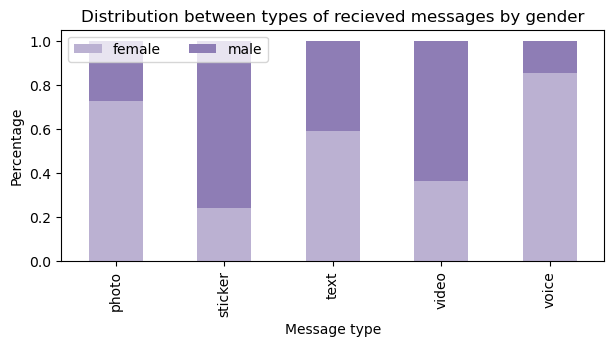

In [364]:
colors = ['#BBB1D2', '#8E7DB5']
tab_gender_sent.plot(kind = 'bar', stacked = True, color = colors, figsize = (7,3))
plt.legend(['female', 'male'], loc="upper left", ncol = 2, fontsize = 10)
plt.ylabel('Percentage', fontsize = 10)
plt.xlabel('Message type', fontsize = 10)
plt.title('Distribution between types of sent messages by gender', fontsize = 12)

tab_gender_rec.plot(kind = 'bar', stacked = True, color = colors, figsize = (7,3))
plt.legend(['female', 'male'], loc="upper left", ncol = 2, fontsize = 10)
plt.ylabel('Percentage', fontsize = 10)
plt.xlabel('Message type', fontsize = 10)
plt.title('Distribution between types of recieved messages by gender', fontsize = 12)

plt.show()

### 24. Countries mentioned in the last 10000 messages.

#### I wanted to see which countries are currently the most discussed.

In [280]:
translator = Translator()

In [404]:
df2 = df.copy()
df2['date'] = pd.to_datetime(df2['date']).dt.date
df2 = df2.sort_values('date', ascending = False)
df2 = df2.head(10000)

In [396]:
def get_countries(df):
    countries = []
    for ind in df.index:
        txt = translator.translate(df['message'][ind]).text
        for country in pycountry.countries:
            if country.name in txt:
                countries.append(country.alpha_3)
        if 'Russia' in txt:
            countries.append('RUS')
        if 'USA' in txt:
            countries.append('USA')
    return countries

In [411]:
countries_last = get_countries(df2)
country_count = pd.value_counts(np.array(countries_last))
country_count = dict(country_count)
list_val = list(country_count)
list_count = list(country_count.values())

In [417]:
choropleth_map = go.Figure(
    data = {
        'type':'choropleth',
        'locationmode':'ISO-3',        
        'locations':list_val,
        'colorscale':'purp',
        'z':list_count,                  
        'colorbar':{'title':'times mentioned'},
    },     
    layout = {
        'title':{
          'text':'Countries mentioned in the last 10000 messages', 
            'x' : 0.45
        },
      'geo':{
          'scope':'world'
      }  
    })
choropleth_map

#### Conclusion: because of the war, Ukraine and russia are the most discussed countries, as I expected

I added this screenshot in case the image does not show up

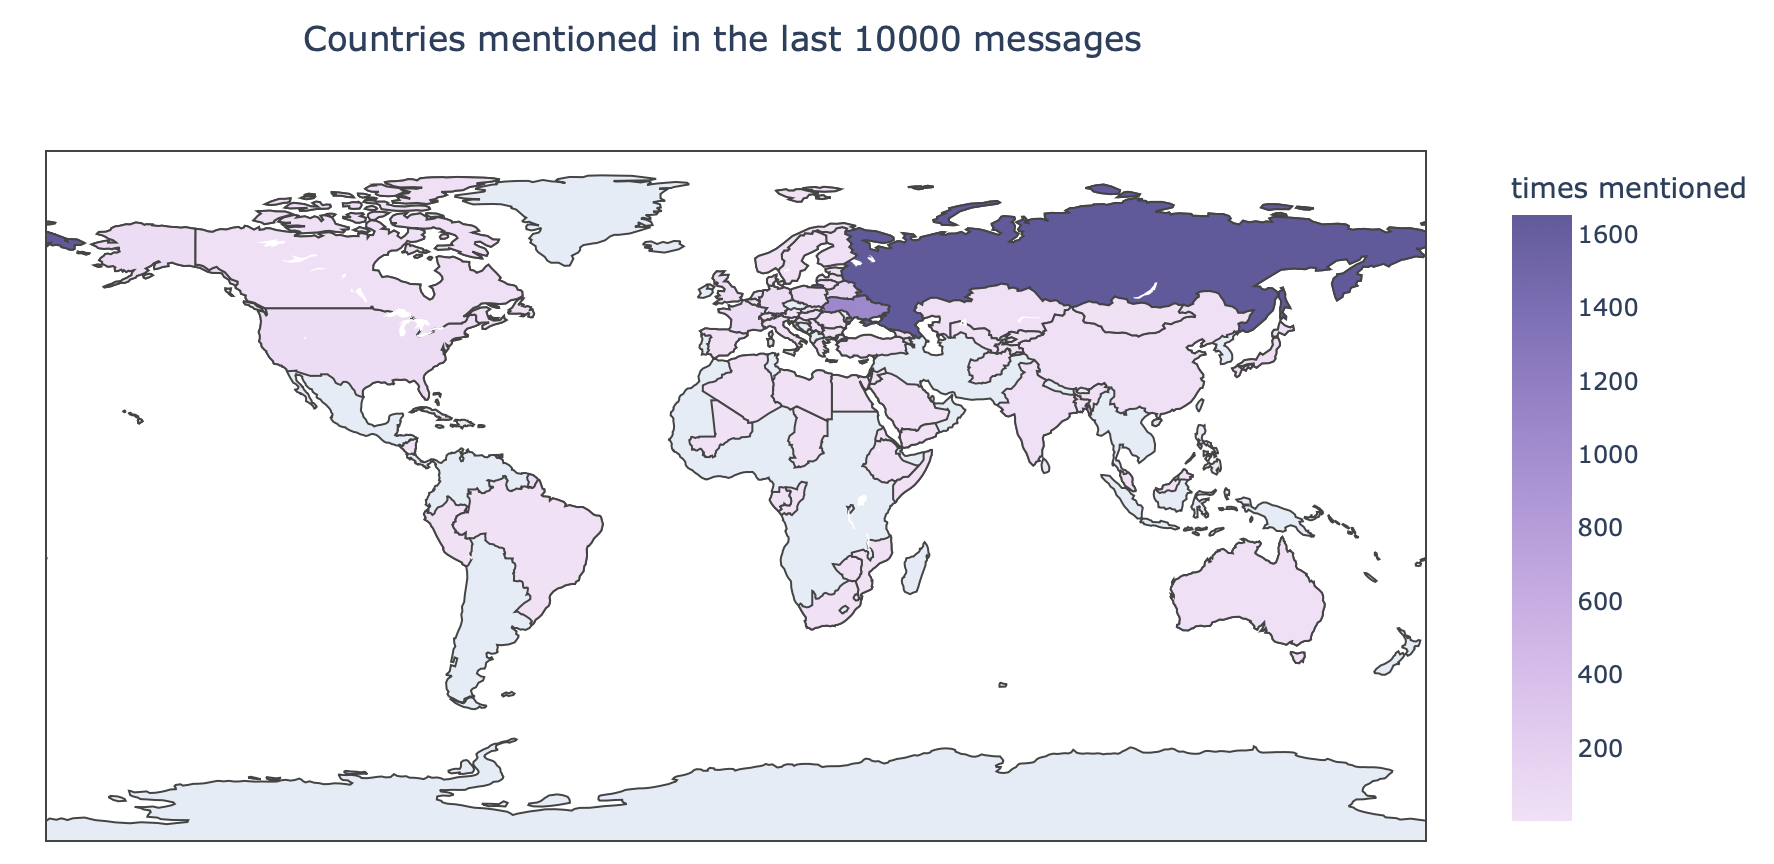